<a href="https://colab.research.google.com/github/fahadrafiq94/Deep-Learning/blob/main/Pose%20Estimation%20Time%20series%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skeleton Data time series classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 1. Exercise 1


Create a data set import script<br>
1. Load the time series movement sequence data set in the .csv format. The sequences
are time recordings of movements (joint angles) with different lengths. Labels are
given in the file names.<br>
2. Try to visualize the data to get a first idea

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import csv
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
np.random.seed(42)

### 1.1 Loading the dataset

In [ ]:
import os
import csv
import pandas as pd

def load_dataset(directory):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            # Extract label from the filename
            label = filename.split("_")[-1].split(".")[0]

            # create an empty list
            file_data = []

            # Read the CSV file
            with open(file_path, 'r') as file:
                csv_reader = csv.reader(file)

                # Read header
                header = next(csv_reader)

                for row in csv_reader:
                    try:
                        # Converting string values to floats
                        row = [float(value) for value in row]

                        # Appending the row to the data
                        file_data.append(row)
                    except ValueError as e:
                        print(f"Error parsing line in file {file_path}: {e}")

            max_columns = max(len(row) for row in file_data)

            # Padding each row with NaN values for missing columns
            padded_data = [row + [float('nan')] * (max_columns - len(row)) for row in file_data]

            # Converting the list to a DataFrame
            df = pd.DataFrame(padded_data, columns=range(max_columns))

            data.append(df)
            labels.append(label)

    return data, labels


In [ ]:
dataset_directory = "/content/drive/MyDrive/lsd_dataset_portfolio_3/train"

# Load the dataset
movement_data, movement_labels = load_dataset(dataset_directory)

In [ ]:
movement_data[0], movement_labels[0]

(        0      1    2      3      4    5      6      7    8      9   ...  \
 0    316.0  109.0  1.0  314.0  203.0  1.0  246.0  202.0  1.0  219.0  ...   
 1    316.0  109.0  1.0  314.0  203.0  1.0  246.0  202.0  1.0  219.0  ...   
 2    316.0  109.0  1.0  314.0  203.0  1.0  246.0  202.0  1.0  219.0  ...   
 3    316.0  109.0  1.0  314.0  203.0  1.0  246.0  202.0  1.0  219.0  ...   
 4    316.0  109.0  1.0  314.0  203.0  1.0  246.0  202.0  1.0  219.0  ...   
 ..     ...    ...  ...    ...    ...  ...    ...    ...  ...    ...  ...   
 324  328.0  111.0  1.0  319.0  202.0  1.0  250.0  201.0  1.0  230.0  ...   
 325  327.0  111.0  1.0  319.0  202.0  1.0  249.0  201.0  1.0  230.0  ...   
 326  326.0  111.0  1.0  317.0  202.0  1.0  249.0  201.0  1.0  230.0  ...   
 327  325.0  111.0  1.0  317.0  202.0  1.0  249.0  201.0  1.0  230.0  ...   
 328  325.0  111.0  1.0  317.0  202.0  1.0  249.0  201.0  1.0  230.0  ...   
 
             69         70   71         72         73   74        75      

### 1.2. Visualizing the data

In [ ]:
def visualize_poses_and_angles(df, keypoint_indices, angle_indices, label_name="", num_rows=None):
    # Extract X, Y coordinates, and Confidence for keypoints
    x_values = df.iloc[:, keypoint_indices]
    y_values = df.iloc[:, np.array(keypoint_indices) + 1]
    confidence_values = df.iloc[:, np.array(keypoint_indices) + 2]

    # Extract angle values
    angle_values = df.iloc[:, angle_indices]

    # Determine the number of rows to visualize
    if num_rows is not None:
        x_values = x_values.head(num_rows)
        y_values = y_values.head(num_rows)
        confidence_values = confidence_values.head(num_rows)
        angle_values = angle_values.head(num_rows)

    # Create a subplot with two columns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    # Plot keypoints in the first subplot
    scatter = axes[0].scatter(x_values, y_values, c=confidence_values, cmap='viridis', s=20)
    axes[0].set_title(f"2D Pose Plot - {label_name}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # Add colorbar to the first subplot
    cbar = fig.colorbar(scatter, ax=axes[0], label="Confidence")

    # Plot angles for selected rows using time series line plot in the second subplot
    for angle_index in angle_indices:
        axes[1].plot(angle_values.index, angle_values[angle_index], label=f'Angle {angle_index}')

    axes[1].set_title(f"Angles - {label_name}")
    axes[1].set_xlabel("Time (Row Index)")
    axes[1].set_ylabel("Angle Value")
    axes[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

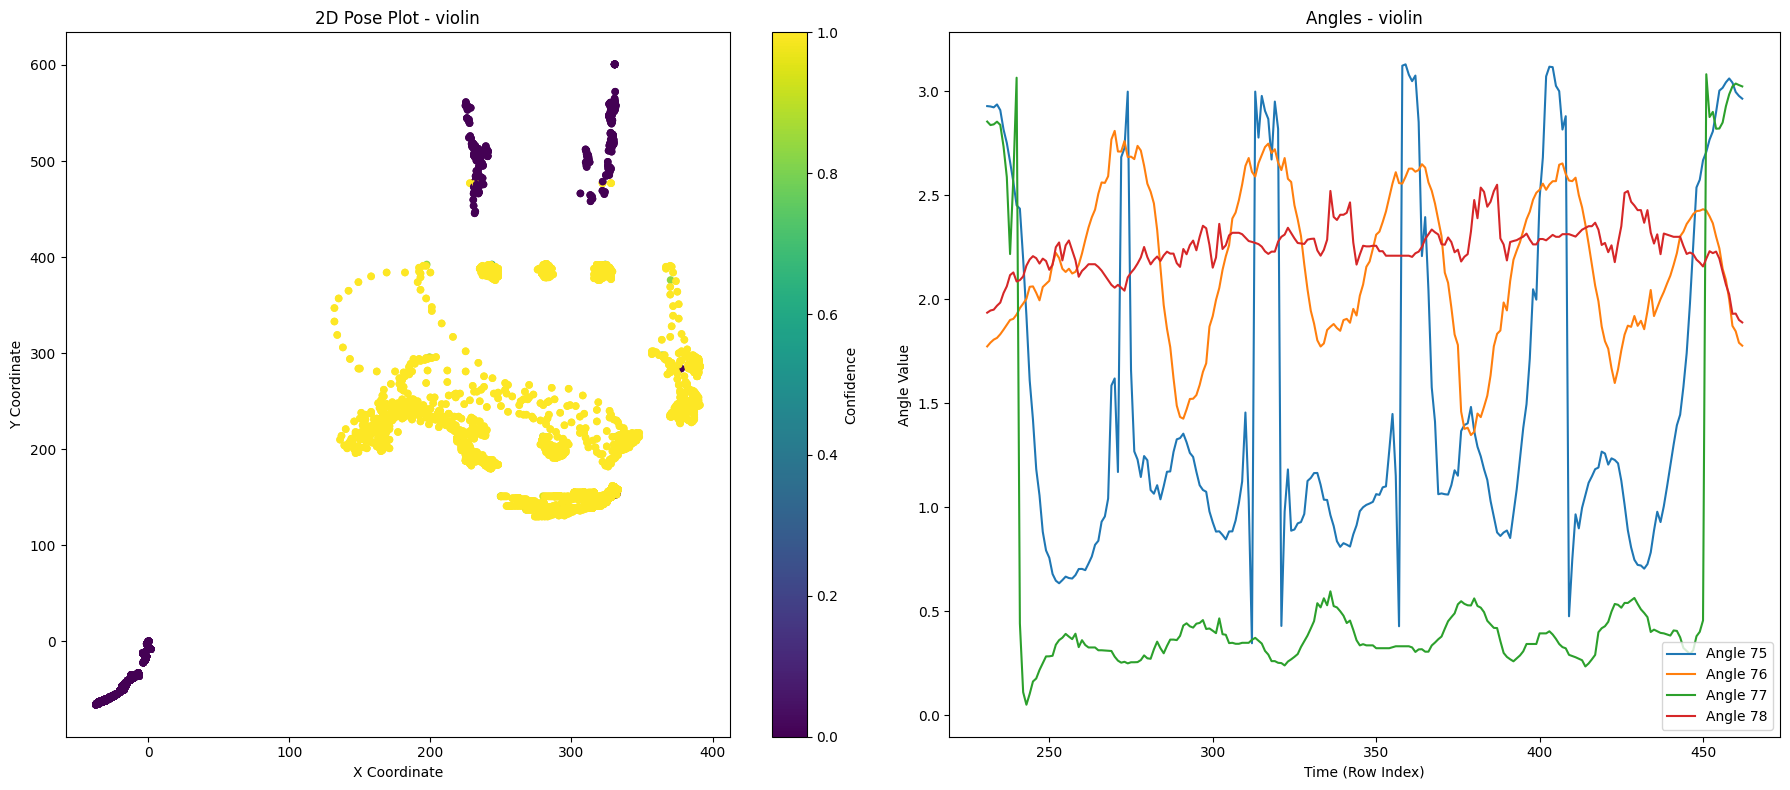

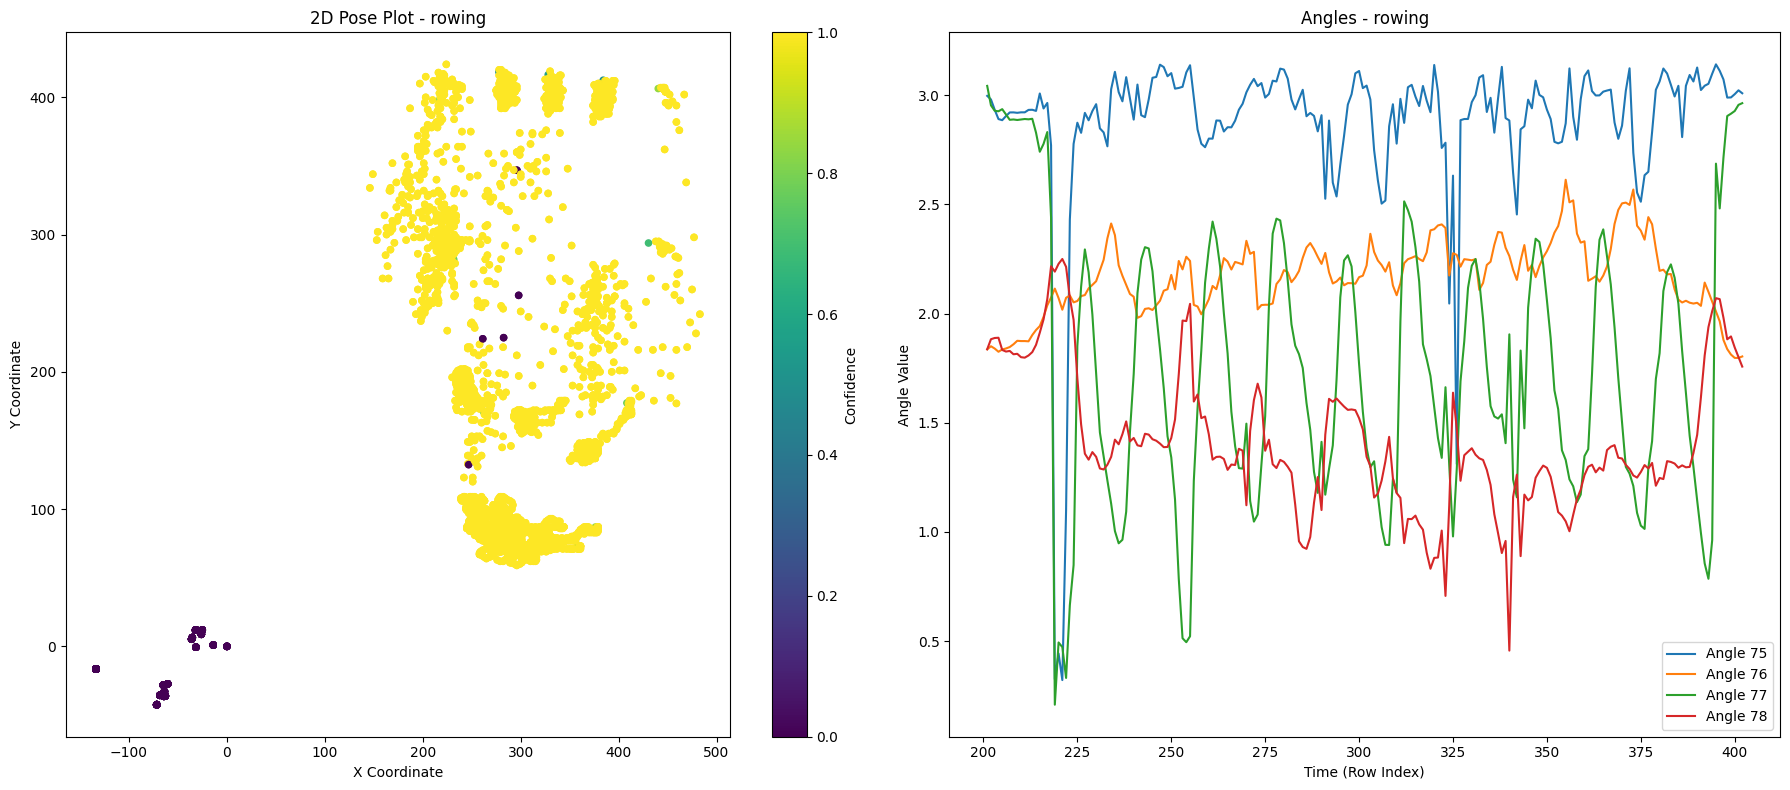

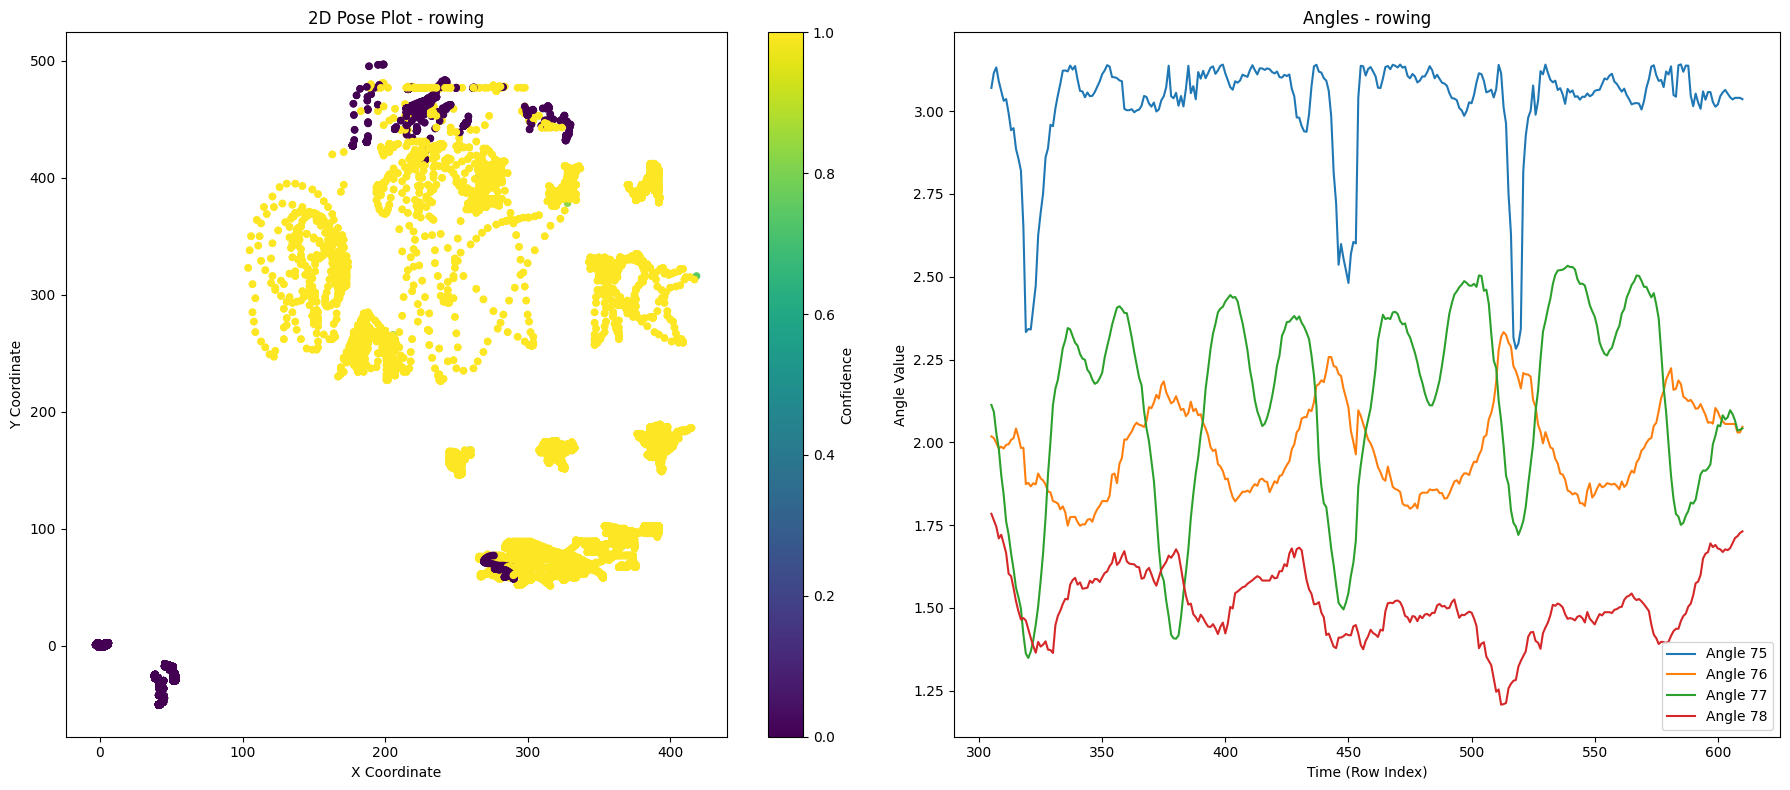

In [ ]:
# Defining keypoint and angle indices
keypoint_indices = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72]
angle_indices = [75, 76, 77, 78]
for i in np.random.choice(range(1167), 3):
    visualize_poses_and_angles(movement_data[i], keypoint_indices, angle_indices, label_name=movement_labels[i], num_rows=None)


### 1.3 Data Duplication

In [ ]:
# Keeping the first 75 columns and the first half of the rows in each dataframe
trimmed_dataframes = [df.iloc[len(df)//2:, :79] for df in movement_data]

# Displaying the shape of the first few trimmed dataframes
for i, df in enumerate(trimmed_dataframes[:5]):
    print(f"DataFrame {i+1} shape: {df.shape}")


DataFrame 1 shape: (165, 79)
DataFrame 2 shape: (349, 79)
DataFrame 3 shape: (307, 79)
DataFrame 4 shape: (245, 79)
DataFrame 5 shape: (163, 79)


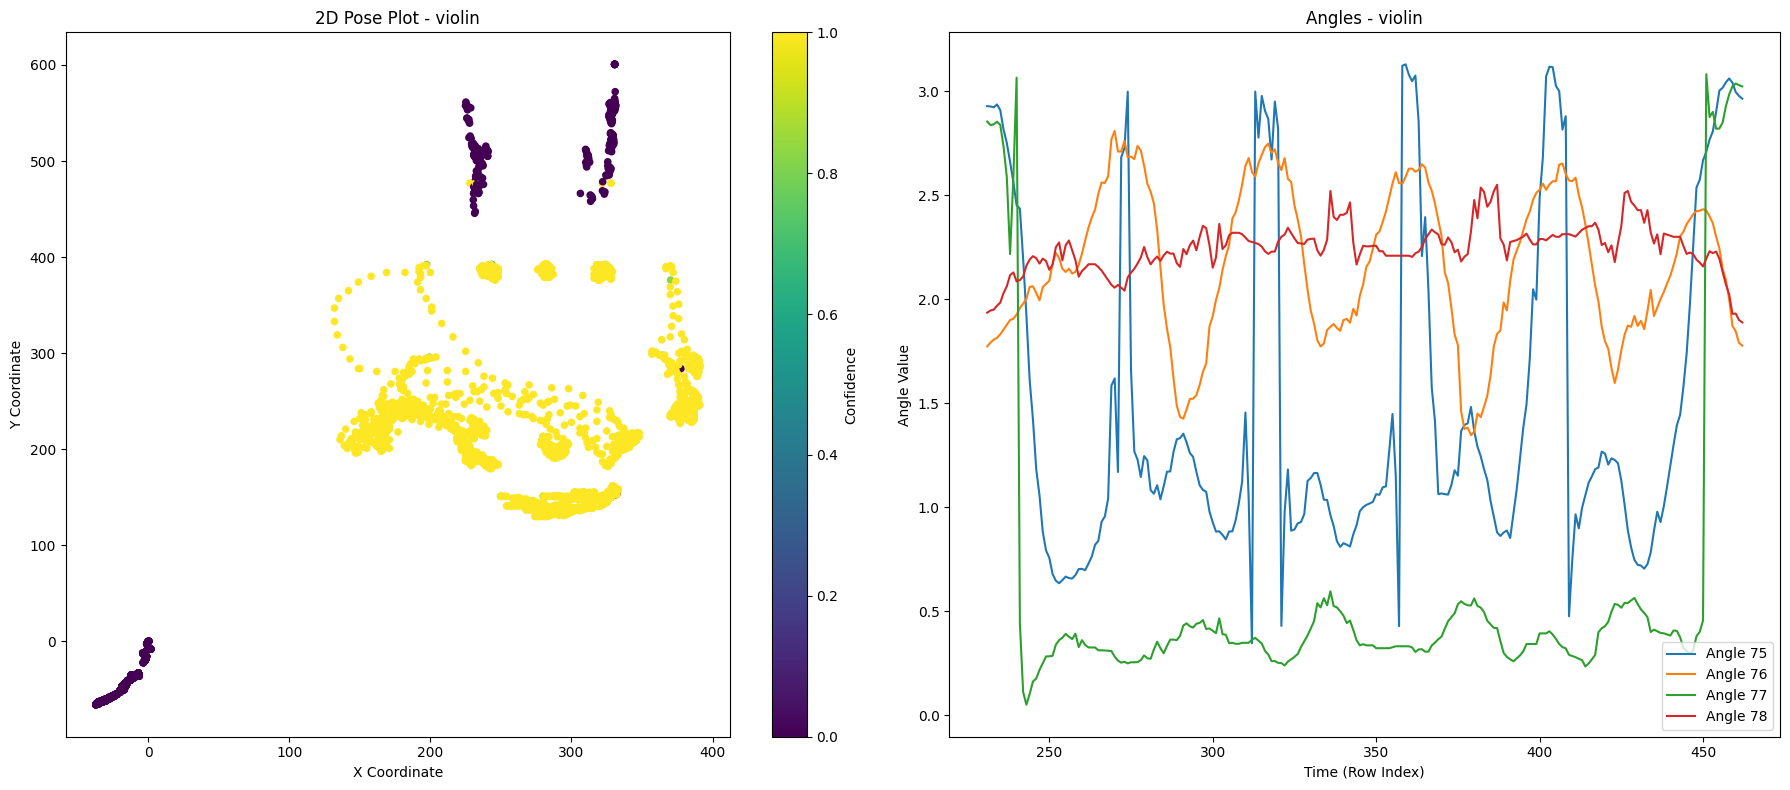

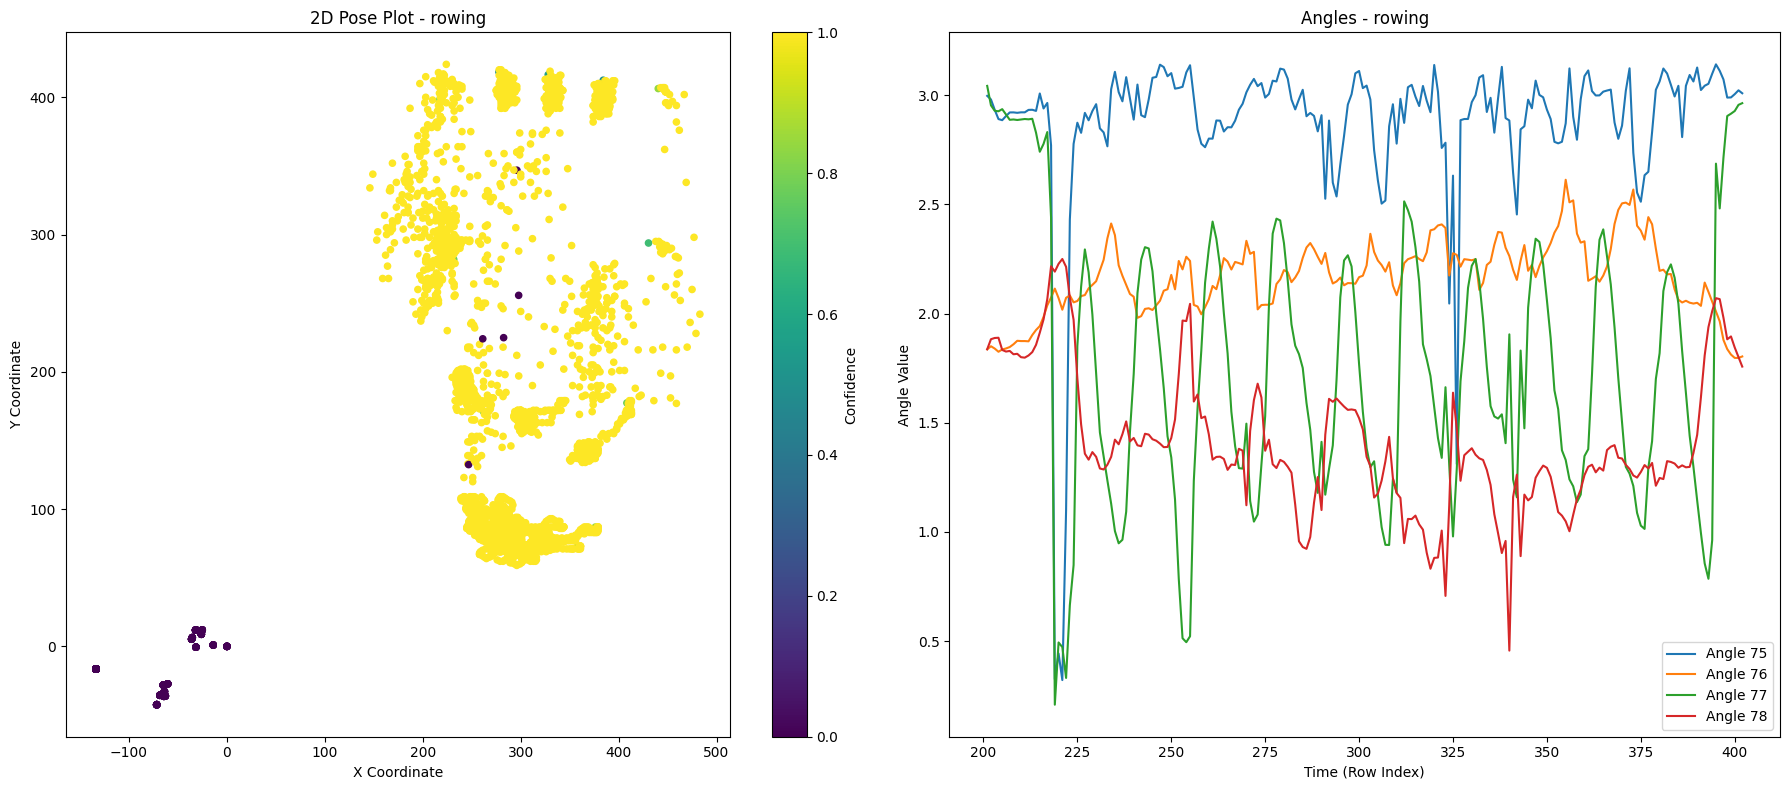

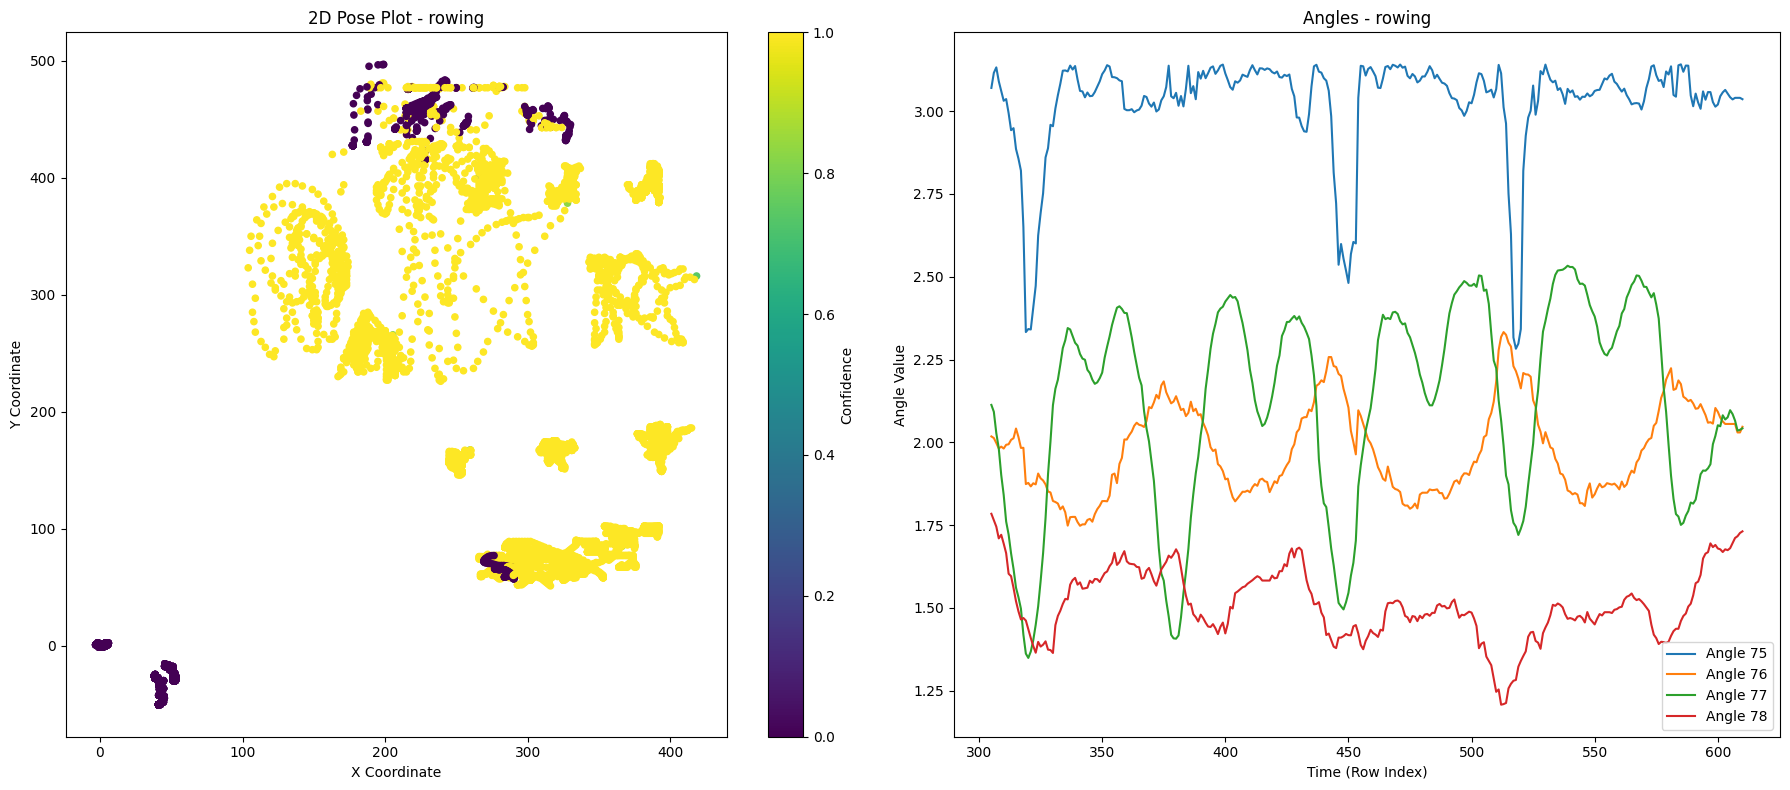

In [ ]:
# Defining keypoint and angle indices
np.random.seed(42)
keypoint_indices = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72]
angle_indices = [75, 76, 77, 78]
for i in np.random.choice(range(1167), 3):
    visualize_poses_and_angles(trimmed_dataframes[i], keypoint_indices, angle_indices, label_name=movement_labels[i], num_rows=None)


## Exercise No 2

## 2.1. Getting data ready for Model


In [ ]:
# Keeping the first 75 columns and the first half of the rows in each dataframe
train_data_frame_list = [df.iloc[:, :75] for df in movement_data]

# Displaying the shape of the first few trimmed dataframes
for i, df in enumerate(train_data_frame_list[:5]):
    print(f"DataFrame {i+1} shape: {df.shape}")

DataFrame 1 shape: (329, 75)
DataFrame 2 shape: (697, 75)
DataFrame 3 shape: (613, 75)
DataFrame 4 shape: (489, 75)
DataFrame 5 shape: (325, 75)


### 2.1. Filling nan in X and y columns with Zero Confidence

In [ ]:
#First fill the x and y of the parts with confidence level 0 as NaN
import pandas as pd
import numpy as np

# Assume train_data_list is a list containing multiple DataFrames
for df in train_data_frame_list:
    # Traverse the columns of the data frame. If the value of the column with index 2 is 0, set the values of the columns with index 0 and 1 to NaN.
    for i in range(2, df.shape[1], 3): # Assume that the column index starts from 0 and the step size is 3
        df.loc[df.iloc[:, i] == 0, df.columns[i-2:i]] = np.nan

In [ ]:
train_data_frame_list[0]

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,316.0,109.0,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1,316.0,109.0,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,316.0,109.0,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,316.0,109.0,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
4,316.0,109.0,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,328.0,111.0,1.0,319.0,202.0,1.0,250.0,201.0,1.0,230.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
325,327.0,111.0,1.0,319.0,202.0,1.0,249.0,201.0,1.0,230.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
326,326.0,111.0,1.0,317.0,202.0,1.0,249.0,201.0,1.0,230.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
327,325.0,111.0,1.0,317.0,202.0,1.0,249.0,201.0,1.0,230.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


### 2.2. Removing the nose, ear and eyes

In [ ]:
# Index for nose, eyes and ears
parts_to_drop = [0, 15, 16, 17, 18]

# Calculate the column index to be deleted
columns_to_drop = []
for idx in parts_to_drop:
    columns_to_drop.extend([idx * 3, idx * 3 + 1]) # x and y coordinates

# Delete the relevant columns of each DataFrame in train_data_frame_list
for df in train_data_frame_list:
    df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
train_data_frame_list[0]

,2,3,4,5,6,7,8,9,10,11,...,65,66,67,68,69,70,71,72,73,74
0,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,313.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,313.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,313.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,313.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
4,1.0,314.0,203.0,1.0,246.0,202.0,1.0,219.0,313.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,1.0,319.0,202.0,1.0,250.0,201.0,1.0,230.0,307.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
325,1.0,319.0,202.0,1.0,249.0,201.0,1.0,230.0,307.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
326,1.0,317.0,202.0,1.0,249.0,201.0,1.0,230.0,310.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
327,1.0,317.0,202.0,1.0,249.0,201.0,1.0,230.0,310.0,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


### 2.3. Dropping the confidence columns

In [ ]:
# 根据列索引而不是列名来删除列
for df in train_data_frame_list:
    # 计算需要删除的列索引列表
    columns_to_drop = [i for i in range(2, 75, 3)]
    # 直接使用整数索引列表来删除列
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
train_data_frame_list[8]

### 2.4. Fixing Data lenght

In [ ]:
def cut_data(data_frame_list, max_rows=150):
    cut_data_frame_list = []
    for df in data_frame_list:
        if len(df) > max_rows:
            cut_df = df.iloc[:max_rows].copy()  # 创建一个副本
        else:
            cut_df = df.reindex(range(max_rows)).fillna(0).copy()  # 重建索引，填充0，然后创建副本
        cut_data_frame_list.append(cut_df)
    return cut_data_frame_list

train_cut_data = cut_data(train_data_frame_list)

In [ ]:
train_cut_data[0]

,3,4,6,7,9,10,12,13,15,16,...,60,61,63,64,66,67,69,70,72,73
0,314.0,203.0,246.0,202.0,219.0,313.0,215.0,425.0,380.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,314.0,203.0,246.0,202.0,219.0,313.0,214.0,426.0,380.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,314.0,203.0,246.0,202.0,219.0,313.0,213.0,427.0,380.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,314.0,203.0,246.0,202.0,219.0,313.0,211.0,426.0,380.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,314.0,203.0,246.0,202.0,219.0,313.0,210.0,427.0,380.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,332.0,202.0,267.0,199.0,215.0,300.0,192.0,413.0,396.0,215.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,332.0,202.0,265.0,199.0,219.0,301.0,194.0,413.0,396.0,215.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,331.0,202.0,264.0,199.0,223.0,301.0,197.0,414.0,395.0,215.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,330.0,202.0,263.0,199.0,226.0,301.0,199.0,416.0,395.0,215.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.5. Normalizing the data

In [ ]:
# Initialize lists to store means and standard deviations
means = []
stds = []

# Calculate mean and standard deviation for each column across all dataframes
for i in range(train_cut_data[0].shape[1]):
    column_values = pd.concat([df.iloc[:, i] for df in train_cut_data])
    means.append(column_values.mean())
    stds.append(column_values.std())

# List for storing normalized dataframes
normalized_dataframes = []

# Normalizing each dataframe
for df in train_cut_data:
    normalized_df = df.copy()
    for i in range(normalized_df.shape[1]):
        normalized_df.iloc[:, i] = (normalized_df.iloc[:, i] - means[i]) / stds[i]
    normalized_dataframes.append(normalized_df.fillna(0))


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd

def extract_statistical_features(series):
    # 假设 `series` 是一个形状为 (samples, time_steps, features) 的三维数组
    # 我们要在时间步长上计算统计数据，因此需要将其重塑为二维数组
    series_reshaped = series.reshape((series.shape[0], -1))  # (samples, time_steps * features)
    features = {
        'mean': np.mean(series_reshaped, axis=1),
        'std': np.std(series_reshaped, axis=1),
        'min': np.min(series_reshaped, axis=1),
        'max': np.max(series_reshaped, axis=1),
        'skew': skew(series_reshaped, axis=1),
        'kurtosis': kurtosis(series_reshaped, axis=1)
    }
    return pd.DataFrame(features)

# 使用示例：
# 假设 `train_normalized_data_list_not_drop` 是一个三维数组
train_stat_features = extract_statistical_features(np.array(normalized_dataframes))


In [ ]:
train_stat_features

,mean,std,min,max,skew,kurtosis
0,0.452775,0.692463,-1.016989,2.741845,0.958182,-0.261089
1,-0.153351,0.746065,-4.007122,2.131111,-1.198965,3.462948
2,0.017285,0.442510,-2.051482,1.979701,-1.164511,5.717778
3,-0.264769,0.387105,-1.445917,0.727999,-0.558183,-0.442285
4,-0.083866,0.473615,-1.179585,1.580903,0.430088,2.093936
...,...,...,...,...,...,...
1162,0.117741,0.922043,-2.886416,3.103983,-0.038777,0.590993
1163,-0.031678,0.545727,-1.936372,2.306327,-0.430705,0.781303
1164,-0.232654,0.757236,-3.767319,1.639027,-1.443709,2.917612
1165,0.375614,0.799301,-1.863148,2.769962,0.809954,0.244978


### 2.6. Loading and preparing test data


In [ ]:
def load_test_dataset(directory):

    data = []

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)

            # create an empty list
            file_data = []

            # Read the CSV file
            with open(file_path, 'r') as file:
                csv_reader = csv.reader(file)

                # Read header
                header = next(csv_reader)

                for row in csv_reader:
                    try:
                        # Converting string values to floats
                        row = [float(value) for value in row]

                        # Appending the row to the data
                        file_data.append(row)
                    except ValueError as e:
                        print(f"Error parsing line in file {file_path}: {e}")

            max_columns = max(len(row) for row in file_data)

            # Pading each row with NaN values for missing columns
            padded_data = [row + [np.nan] * (max_columns - len(row)) for row in file_data]

            # Converting the list to a DataFrame
            df = pd.DataFrame(padded_data, columns=range(max_columns))

            data.append(df)


    return data

In [ ]:
folder_path = "/content/drive/MyDrive/lsd_dataset_portfolio_3/test"
test_data =  load_test_dataset(folder_path)

In [ ]:
test_data_frame_list= [df.iloc[:,:75] for df in test_data]

In [ ]:
for i, df in enumerate(test_data_frame_list):
    rows, cols = df.shape
    print(f"DataFrame {i}: {rows} rows, {cols} columns")

DataFrame 0: 559 rows, 75 columns
DataFrame 1: 425 rows, 75 columns
DataFrame 2: 399 rows, 75 columns
DataFrame 3: 585 rows, 75 columns
DataFrame 4: 725 rows, 75 columns
DataFrame 5: 1383 rows, 75 columns
DataFrame 6: 583 rows, 75 columns
DataFrame 7: 873 rows, 75 columns
DataFrame 8: 1019 rows, 75 columns
DataFrame 9: 457 rows, 75 columns
DataFrame 10: 571 rows, 75 columns
DataFrame 11: 329 rows, 75 columns
DataFrame 12: 321 rows, 75 columns
DataFrame 13: 477 rows, 75 columns
DataFrame 14: 1215 rows, 75 columns
DataFrame 15: 705 rows, 75 columns
DataFrame 16: 615 rows, 75 columns
DataFrame 17: 661 rows, 75 columns
DataFrame 18: 551 rows, 75 columns
DataFrame 19: 635 rows, 75 columns
DataFrame 20: 1175 rows, 75 columns
DataFrame 21: 601 rows, 75 columns
DataFrame 22: 1023 rows, 75 columns
DataFrame 23: 685 rows, 75 columns
DataFrame 24: 581 rows, 75 columns
DataFrame 25: 755 rows, 75 columns
DataFrame 26: 371 rows, 75 columns
DataFrame 27: 283 rows, 75 columns
DataFrame 28: 1279 rows, 

In [ ]:
#First fill the x and y of the parts with confidence level 0 as NaN
import pandas as pd
import numpy as np

# Assume train_data_list is a list containing multiple DataFrames
for df in test_data_frame_list:
    # Traverse the columns of the data frame. If the value of the column with index 2 is 0, set the values of the columns with index 0 and 1 to NaN.
    for i in range(2, df.shape[1], 3): # Assume that the column index starts from 0 and the step size is 3
        df.loc[df.iloc[:, i] == 0, df.columns[i-2:i]] = np.nan

In [ ]:
test_data_frame_list[0]

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,308.0,93.0,1.0,310.0,163.0,1.0,248.0,167.0,1.0,210.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1,307.0,91.0,1.0,308.0,163.0,1.0,246.0,167.0,1.0,208.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,306.0,89.0,1.0,307.0,163.0,1.0,247.0,167.0,1.0,207.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
3,305.0,88.0,1.0,306.0,163.0,1.0,246.0,167.0,1.0,206.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
4,304.0,87.0,1.0,305.0,163.0,1.0,245.0,167.0,1.0,206.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,291.0,95.0,1.0,301.0,166.0,1.0,242.0,167.0,1.0,203.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
555,291.0,95.0,1.0,301.0,166.0,1.0,242.0,167.0,1.0,203.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
556,291.0,95.0,1.0,301.0,166.0,1.0,242.0,167.0,1.0,202.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
557,291.0,96.0,1.0,301.0,166.0,1.0,242.0,167.0,1.0,201.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [ ]:
parts_to_drop = [0, 15, 16, 17, 18]

# Calculate the column index to be deleted
columns_to_drop = []
for idx in parts_to_drop:
    columns_to_drop.extend([idx * 3, idx * 3 + 1]) # x and y coordinates

# Delete the relevant columns of each DataFrame in train_data_frame_list
for df in test_data_frame_list:
    df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# 根据列索引而不是列名来删除列
for df in test_data_frame_list:
    # 计算需要删除的列索引列表
    columns_to_drop = [i for i in range(2, 75, 3)]
    # 直接使用整数索引列表来删除列
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
test_cut_data = cut_data(test_data_frame_list)

In [ ]:
# List for storing normalized test dataframes
normalized_test_dataframes = []

# Normalize each test dataframe using the means and stds from training data
for test_df in test_cut_data:
    normalized_test_df = test_df.copy()
    for i in range(normalized_test_df.shape[1]):
        normalized_test_df.iloc[:, i] = (normalized_test_df.iloc[:, i] - means[i]) / stds[i]
    normalized_test_dataframes.append(normalized_test_df.fillna(0))

In [ ]:
normalized_test_dataframes[0].head()

,3,4,6,7,9,10,12,13,15,16,...,60,61,63,64,66,67,69,70,72,73
0,-0.183319,-0.661791,-0.090196,-0.46656,-0.132958,-0.346254,0.174427,-0.349474,-0.504279,-1.022315,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.267252,-0.661791,-0.173637,-0.46656,-0.189685,-0.029615,0.174427,-0.445246,-0.541944,-0.972246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.309218,-0.661791,-0.131917,-0.46656,-0.218049,-0.029615,0.191208,-0.513655,-0.579610,-0.972246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.351185,-0.661791,-0.173637,-0.46656,-0.246413,-0.029615,0.040183,-0.499973,-0.617275,-0.972246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.393152,-0.661791,-0.215358,-0.46656,-0.246413,-0.000830,0.023403,-0.472610,-0.654941,-0.972246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd

def extract_statistical_features(series):
    # 假设 `series` 是一个形状为 (samples, time_steps, features) 的三维数组
    # 我们要在时间步长上计算统计数据，因此需要将其重塑为二维数组
    series_reshaped = series.reshape((series.shape[0], -1))  # (samples, time_steps * features)
    features = {
        'mean': np.mean(series_reshaped, axis=1),
        'std': np.std(series_reshaped, axis=1),
        'min': np.min(series_reshaped, axis=1),
        'max': np.max(series_reshaped, axis=1),
        'skew': skew(series_reshaped, axis=1),
        'kurtosis': kurtosis(series_reshaped, axis=1)
    }
    return pd.DataFrame(features)

# 使用示例：
# 假设 `train_normalized_data_list_not_drop` 是一个三维数组
test_stat_features = extract_statistical_features(np.array(normalized_test_dataframes))


In [ ]:
test_stat_features

,mean,std,min,max,skew,kurtosis
0,-0.020721,0.672612,-1.544608,2.120993,0.139394,0.461400
1,-0.117661,0.604466,-1.490602,1.248380,-0.850261,0.298107
2,-0.102532,0.610266,-2.821793,2.013410,-0.150888,1.919937
3,-0.194755,0.711474,-2.756872,1.616894,-0.690473,0.142717
4,-0.188690,0.649175,-3.198456,1.976421,-1.501956,4.528562
...,...,...,...,...,...,...
300,0.190115,0.754043,-1.227956,2.195830,0.479132,-0.206311
301,0.024472,0.491342,-1.868222,1.716468,-0.082674,1.867564
302,0.018011,0.507426,-2.009980,1.916613,-0.044239,1.669052
303,-0.265787,0.809941,-3.249141,1.520747,-0.689699,0.222072


### 2.7. Modeling

#### 2.7.1 Label Encoding

In [ ]:
# Your label mapping
label_mapping = {
    "boxing": 0,
    "drums": 1,
    "guitar": 2,
    "rowing": 3,
    "violin": 4
}

# Assuming 'labels' is your list of original labels
original_labels = ["boxing", "drums", "guitar", "rowing", "violin"]

# Map the original labels to their corresponding numbers
train_labels_df = [label_mapping[label] for label in movement_labels]

# Display the mapped labels
print(train_labels_df)


[4, 3, 3, 2, 2, 3, 2, 4, 3, 4, 2, 2, 4, 3, 3, 1, 2, 2, 1, 1, 4, 3, 1, 4, 0, 4, 4, 4, 1, 4, 4, 2, 1, 0, 2, 4, 0, 1, 3, 2, 3, 4, 2, 0, 4, 3, 4, 2, 4, 1, 0, 2, 4, 4, 3, 1, 0, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 4, 0, 2, 3, 4, 1, 3, 3, 0, 4, 0, 1, 2, 4, 2, 4, 3, 3, 4, 3, 0, 4, 1, 1, 1, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 1, 2, 1, 1, 3, 4, 1, 2, 2, 1, 3, 3, 1, 2, 0, 0, 4, 1, 1, 0, 0, 3, 0, 2, 1, 0, 4, 1, 3, 0, 4, 0, 0, 3, 1, 1, 4, 4, 1, 2, 1, 2, 2, 3, 0, 1, 3, 3, 4, 0, 3, 2, 3, 3, 4, 3, 4, 4, 1, 2, 2, 4, 3, 0, 3, 1, 3, 0, 0, 0, 3, 2, 3, 2, 0, 2, 2, 3, 4, 3, 1, 3, 1, 4, 2, 4, 4, 1, 0, 1, 0, 0, 1, 0, 4, 0, 1, 1, 2, 3, 4, 1, 2, 3, 1, 3, 0, 3, 1, 3, 0, 3, 4, 3, 0, 4, 4, 0, 0, 4, 0, 0, 0, 3, 1, 0, 1, 3, 4, 4, 1, 4, 2, 1, 2, 0, 0, 4, 1, 4, 0, 2, 2, 3, 1, 2, 0, 2, 0, 1, 0, 3, 0, 3, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 3, 1, 2, 2, 3, 0, 0, 4, 3, 4, 1, 0, 4, 0, 4, 4, 0, 0, 1, 2, 3, 0, 2, 4, 3, 0, 2, 3, 2, 4, 1, 3, 0, 0, 1, 4, 3, 4, 2, 4, 0, 4, 4, 1, 2, 4, 1, 0, 0, 2, 2, 1, 1, 4, 1, 1, 2, 1, 0, 0, 1, 1, 4, 0, 1, 4, 3, 

#### 2.7.2. LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])  # 只取序列的最后一个时间步的输出
        return out

In [ ]:
from torch.utils.data import TensorDataset

# 假设 train_sequences 是一个三维数组，形状为 (num_samples, 150, 30)
# encoded_labels 是对应的标签，形状为 (num_samples,)

# 将数据转换为张量
X_tensor = torch.tensor([df.values for df in normalized_dataframes], dtype=torch.float32)
# 如果train_normalized_data_list是一个DataFrame列表
# y_tensor = torch.tensor(train_labels_df['label'].values, dtype=torch.long).squeeze()
y_tensor = torch.tensor(train_labels_df, dtype=torch.long)

# 分割数据集
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [ ]:
# 初始化模型
input_dim = 40  # input feature dimension
hidden_dim = 106  # 隐藏层维度
layer_dim = 3  # LSTM层的数量
output_dim = 5  # 输出维度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0, 0
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == y).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == y).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    print(f'Epoch {epoch}/{num_epochs}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

Epoch 0/50: Train Loss: 0.04661219909643437, Train Acc: 0.3536977491961415, Val Loss: 0.04027449167691744, Val Acc: 0.5341880341880342
Epoch 1/50: Train Loss: 0.02813967570486815, Train Acc: 0.7009646302250804, Val Loss: 0.027560102379220165, Val Acc: 0.7008547008547008
Epoch 2/50: Train Loss: 0.020007496957226964, Train Acc: 0.789924973204716, Val Loss: 0.022007616157205697, Val Acc: 0.7948717948717948
Epoch 3/50: Train Loss: 0.014106667964915881, Train Acc: 0.8585209003215434, Val Loss: 0.016546931340653673, Val Acc: 0.8931623931623932
Epoch 4/50: Train Loss: 0.02011786822912394, Train Acc: 0.8338692390139335, Val Loss: 0.03717072117022979, Val Acc: 0.6666666666666666
Epoch 5/50: Train Loss: 0.025777370855611492, Train Acc: 0.6259378349410504, Val Loss: 0.02832665988522717, Val Acc: 0.6452991452991453
Epoch 6/50: Train Loss: 0.025798009011778672, Train Acc: 0.6730975348338692, Val Loss: 0.02916934525864756, Val Acc: 0.6666666666666666
Epoch 7/50: Train Loss: 0.0222622131866913, Train

In [ ]:
# 测试数据预处理
# 假设 test_sequences 是一个列表，包含DataFrame
X_test = torch.tensor([df.values for df in normalized_test_dataframes], dtype=torch.float32).to(device)

# 进行预测
model.eval()
predictions = []
with torch.no_grad():
    for X in X_test:
        X = X.unsqueeze(0)  # 增加批次维度
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted.item())

# 保存预测结果到CSV
predictions_df = pd.DataFrame(predictions, columns=['action'])
predictions_df.insert(0, 'id', range(len(predictions_df)))
predictions_df.to_csv('submission-delete3f-original1.csv', index=False)

## Exercise No 3

### 3.1. Memeory practical and theoratical Complexity

In [ ]:
# LSTM 包装器类
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from scipy.stats import randint as sp_randint

class LSTMClassifier(BaseEstimator):
    def __init__(self, input_dim=40, hidden_dim=128, layer_dim=4, output_dim=5, learning_rate=0.001):
        super(LSTMClassifier, self).__init__()
        # 初始化参数
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        # 初始化模型
        self.lstm = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
        self.optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lstm.to(self.device)

    def fit(self, X, y, epochs=10, batch_size=32):
        # 正确的缩进：所有的行都用四个空格缩进
        dataset = TensorDataset(X, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lstm.train()
        for epoch in range(epochs):
            for i, (inputs, labels) in enumerate(loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.lstm(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
        return self

    def predict(self, X):
        # 正确的缩进
        self.lstm.eval()
        outputs = self.lstm(X.to(self.device))
        _, predicted = torch.max(outputs.data, 1)
        return predicted.cpu().numpy()


# 参数网格
param_dist = {
    'hidden_dim': sp_randint(32, 256),
    'layer_dim': sp_randint(1, 5)
}

# 使用随机搜索
model = LSTMClassifier(input_dim=40, hidden_dim=128, layer_dim=4, output_dim=5)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2, random_state=42,
                                   scoring=make_scorer(accuracy_score))
X_tensor = torch.tensor([df.values for df in normalized_dataframes], dtype=torch.float32)
# 如果train_normalized_data_list是一个DataFrame列表
y_tensor = torch.tensor(train_labels_df, dtype=torch.long)


# 转换数据以适应 Scikit-Learn
#X_train_tensor = torch.tensor(X_train.numpy(), dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train.numpy(), dtype=torch.long)

# 运行随机搜索
random_search.fit(X_tensor, y_tensor)

# 最佳参数
print("Best Parameters: ", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ........................hidden_dim=134, layer_dim=4; total time=   2.6s
[CV] END ........................hidden_dim=134, layer_dim=4; total time=   2.2s
[CV] END ........................hidden_dim=134, layer_dim=4; total time=   2.1s
[CV] END ........................hidden_dim=124, layer_dim=3; total time=   2.1s
[CV] END ........................hidden_dim=124, layer_dim=3; total time=   2.1s
[CV] END ........................hidden_dim=124, layer_dim=3; total time=   2.2s
[CV] END ........................hidden_dim=138, layer_dim=4; total time=   2.2s
[CV] END ........................hidden_dim=138, layer_dim=4; total time=   2.2s
[CV] END ........................hidden_dim=138, layer_dim=4; total time=   2.2s
[CV] END ........................hidden_dim=220, layer_dim=1; total time=   2.2s
[CV] END ........................hidden_dim=220, layer_dim=1; total time=   2.2s
[CV] END ........................hidden_dim=220,

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, stat_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # 全连接层不仅将接收来自 LSTM 的输出，还将接收统计特征
        self.fc1 = nn.Linear(hidden_dim + stat_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x, stats):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        # LSTM 输出
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # 拼接 LSTM 的最终隐藏状态和统计特征
        # 我们使用 hn，它是最后一个时间步的隐藏状态
        hn = hn[-1]  # 取 LSTM 的最后一层的隐藏状态
        combined = torch.cat((hn, stats), dim=1)  # 在特征维度上拼接

        # 经过全连接层
        out = torch.relu(self.fc1(combined))
        out = self.fc2(out)
        return out

# 训练过程中的数据加载器需要修改以包括统计特征
# 假设 train_stat_features 是一个 DataFrame，其中包含了统计特征
stat_features_tensor = torch.tensor(train_stat_features.values, dtype=torch.float32)

# 拆分数据集以包括统计特征
stat_train, stat_val, _, _ = train_test_split(stat_features_tensor, y_tensor, test_size=0.2, random_state=42)

# 修改 DataLoader 以同时返回时间序列数据和统计特征
train_loader = DataLoader(TensorDataset(X_train, stat_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, stat_val, y_val), batch_size=32, shuffle=False)

# 初始化模型
#model = LSTMModel(input_dim=40, hidden_dim=128, layer_dim=4, output_dim=5, stat_dim=stat_features_tensor.shape[1]).to(device)


change hidden_dim and output_dim

In [ ]:
input_dim = 40  # input feature dimension
hidden_dim = 106  # 隐藏层维度
layer_dim = 3  # LSTM层的数量
output_dim = 5  # 输出维度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型，这里需要确保传入统计特征的维度
model = LSTMModel(input_dim=input_dim,
                  hidden_dim=hidden_dim,
                  layer_dim=layer_dim,
                  output_dim=output_dim,
                  stat_dim=stat_features_tensor.shape[1]).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    train_loss, train_acc = 0, 0

    # 迭代数据加载器
    for i, (X, stats, y) in enumerate(train_loader):
        X, stats, y = X.to(device), stats.to(device), y.to(device)
        # 清除之前的梯度
        optimizer.zero_grad()
        # 执行前向传播，同时传入时间序列数据和统计特征
        outputs = model(X, stats)
        # 计算损失
        loss = criterion(outputs, y)
        # 执行反向传播
        loss.backward()
        # 执行优化（参数更新）
        optimizer.step()
        # 累计损失和准确率
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == y).sum().item()

    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # 验证模型性能
    model.eval()  # 设置模型为评估模式
    val_loss, val_acc = 0, 0
    with torch.no_grad():  # 在评估模式下不计算梯度
        for X, stats, y in val_loader:
            X, stats, y = X.to(device), stats.to(device), y.to(device)
            outputs = model(X, stats)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == y).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # 打印训练和验证的损失与准确率
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/50: Train Loss: 0.0455, Train Acc: 0.3923, Val Loss: 0.0404, Val Acc: 0.4872
Epoch 2/50: Train Loss: 0.0312, Train Acc: 0.6109, Val Loss: 0.0323, Val Acc: 0.7051
Epoch 3/50: Train Loss: 0.0232, Train Acc: 0.7492, Val Loss: 0.0269, Val Acc: 0.7137
Epoch 4/50: Train Loss: 0.0180, Train Acc: 0.8081, Val Loss: 0.0240, Val Acc: 0.7436
Epoch 5/50: Train Loss: 0.0196, Train Acc: 0.7835, Val Loss: 0.0194, Val Acc: 0.7735
Epoch 6/50: Train Loss: 0.0125, Train Acc: 0.8596, Val Loss: 0.0136, Val Acc: 0.8718
Epoch 7/50: Train Loss: 0.0086, Train Acc: 0.9143, Val Loss: 0.0159, Val Acc: 0.8889
Epoch 8/50: Train Loss: 0.0122, Train Acc: 0.8971, Val Loss: 0.0242, Val Acc: 0.7051
Epoch 9/50: Train Loss: 0.0306, Train Acc: 0.6099, Val Loss: 0.0322, Val Acc: 0.6282
Epoch 10/50: Train Loss: 0.0274, Train Acc: 0.6870, Val Loss: 0.0342, Val Acc: 0.6282
Epoch 11/50: Train Loss: 0.0234, Train Acc: 0.7363, Val Loss: 0.0229, Val Acc: 0.7521
Epoch 12/50: Train Loss: 0.0169, Train Acc: 0.8135, Val Loss: 0

In [ ]:
# 假设 test_stat_features 是测试数据的统计特征 DataFrame
# 转换为 Tensor
test_stat_features_tensor = torch.tensor(test_stat_features.values, dtype=torch.float32).to(device)

# 测试数据预处理
X_test = torch.tensor([df.values for df in normalized_test_dataframes], dtype=torch.float32).to(device)

# 进行预测
model.eval()
predictions = []

with torch.no_grad():
    for i, X in enumerate(X_test):
        X = X.unsqueeze(0)  # 增加批次维度
        stats = test_stat_features_tensor[i].unsqueeze(0)  # 获取对应的统计特征并增加批次维度
        outputs = model(X, stats)  # 预测时传入时间序列数据和统计特征
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted.item())

# 保存预测结果到CSV
predictions_df = pd.DataFrame(predictions, columns=['action'])
predictions_df.insert(0, 'id', range(len(predictions_df)))
predictions_df.to_csv('submission-notdrop-delete3feature-addfeaturecount-method2-changeparas-1.csv', index=False)

upon data is delete 3 feature(nose, eye, ear), and not drop other data(like confidence 0 > 90)

In [ ]:
import time
# 初始化模型
input_dim = 40  # input feature dimension
hidden_dim = 131  # 隐藏层维度
layer_dim = 4  # LSTM层的数量
output_dim = 5  # 输出维度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_dim=input_dim,
                  hidden_dim=hidden_dim,
                  layer_dim=layer_dim,
                  output_dim=output_dim,
                  stat_dim=stat_features_tensor.shape[1]).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 计算参数数量
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

# 估计模型内存使用量（以浮点数表示）
memory_bytes = num_params * 4  # 四个字节为一个32位浮点数
memory_megabytes = memory_bytes / (1024 ** 2)
print(f'Estimated model memory usage: {memory_megabytes} MB')

# 测量训练时间
start_train_time = time.time()

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    train_loss, train_acc = 0, 0
    # 迭代数据加载器
    for i, (X, stats, y) in enumerate(train_loader):
        X, stats, y = X.to(device), stats.to(device), y.to(device)
        # 清除之前的梯度
        optimizer.zero_grad()
        # 执行前向传播，同时传入时间序列数据和统计特征
        outputs = model(X, stats)
        # 计算损失
        loss = criterion(outputs, y)
        # 执行反向传播
        loss.backward()
        # 执行优化（参数更新）
        optimizer.step()
        # 累计损失和准确率
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == y).sum().item()

    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # 验证模型性能
    model.eval()  # 设置模型为评估模式
    val_loss, val_acc = 0, 0
    with torch.no_grad():  # 在评估模式下不计算梯度
        for X, stats, y in val_loader:
            X, stats, y = X.to(device), stats.to(device), y.to(device)
            outputs = model(X, stats)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == y).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    # print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

end_train_time = time.time()
print(f'Training time for {num_epochs} epochs: {end_train_time - start_train_time} seconds')

# 测量推理时间
start_infer_time = time.time()

# 假设 test_stat_features 是测试数据的统计特征 DataFrame
# 转换为 Tensor
test_stat_features_tensor = torch.tensor(test_stat_features.values, dtype=torch.float32).to(device)

# 测试数据预处理和进行预测
model.eval()
predictions = []

with torch.no_grad():
    for i, X in enumerate(X_test):
        X = X.unsqueeze(0)  # 增加批次维度
        stats = test_stat_features_tensor[i].unsqueeze(0)  # 获取对应的统计特征并增加批次维度
        outputs = model(X, stats)  # 预测时传入时间序列数据和统计特征
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted.item())

end_infer_time = time.time()
print(f'Inference time: {end_infer_time - start_infer_time} seconds')

predictions_df = pd.DataFrame(predictions, columns=['action'])
predictions_df.insert(0, 'id', range(len(predictions_df)))
predictions_df.to_csv('submission.csv', index=False)

Number of parameters: 523969
Estimated model memory usage: 1.9987831115722656 MB
Training time for 50 epochs: 50.01965832710266 seconds
Inference time: 1.3395123481750488 seconds


<b>Estimating Memory and Runtime Complexity Theoretical Complexity:</b><br>
<b>Memory Complexity:</b>

Training: Memory usage during training depends on the size of the model (number of parameters), the size of the training data, and batch size. In a neural network, memory is required for weights, biases, activations at each layer, and gradients during backpropagation.

Testing: Memory usage during testing is generally lower, as it only requires memory for the model parameters and a single instance or a batch of test data. There's no need to store gradients or activations from multiple layers.

<b>Runtime Complexity:</b>

Training: The runtime complexity depends on the number of epochs, number of layers in the model, and the complexity of each layer (for a dense layer, it is often proportional to the product of input and output sizes). The training time also includes forward and backward passes. Testing: Runtime complexity during testing is typically lower. It involves a single forward pass through the network for each instance or batch of data.

<b>Practical Complexity:</b>

The practical complexity might differ based on the hardware used (CPU vs. GPU), optimization in code, and data loading mechanisms.



### 3.2. Evaluate the resulting model by appropriate evaluation measures (cross- validation,AUC,NMI or alike)

the result of the sparsity part seems have some mistakes, so i did run it completely

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch import nn, optim
import time

# 假设您的LSTM模型已经被定义为 LSTMModel

# 准备数据
# X_tensor, y_tensor, stat_features_tensor 需要事先定义好
X = X_tensor
y = y_tensor
stats = stat_features_tensor

# 定义时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)

# 存储每次分割的评估结果
results = []

# 选择模型参数
input_dim = 40
hidden_dim = 106
layer_dim = 3
output_dim = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50

# 进行交叉验证
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    stats_train, stats_test = stats[train_index], stats[test_index]

    # 将数据包装进DataLoader
    train_loader = DataLoader(TensorDataset(X_train, stats_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_test, stats_test, y_test), batch_size=32, shuffle=False)

    # 初始化模型
    model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, stats.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 存储每个epoch的损失、准确率和验证集预测
    fold_results = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_predictions': [],  # 存储验证集预测
        'y_true': y_test.numpy()  # 存储真实标签
    }

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct, total = 0, 0
        for X_batch, stats_batch, y_batch in train_loader:
            X_batch, stats_batch, y_batch = X_batch.to(device), stats_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch, stats_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        fold_results['train_loss'].append(train_loss / len(train_loader))
        fold_results['train_accuracy'].append(correct / total)

        # 验证模型
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        val_predictions = []
        with torch.no_grad():
            for X_batch, stats_batch, y_batch in val_loader:
                X_batch, stats_batch, y_batch = X_batch.to(device), stats_batch.to(device), y_batch.to(device)
                outputs = model(X_batch, stats_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
                val_predictions.extend(predicted.cpu().numpy())
        fold_results['val_loss'].append(val_loss / len(val_loader))
        fold_results['val_accuracy'].append(correct / total)
        fold_results['val_predictions'].append(val_predictions)

    # 在每个fold结束后计算precision, recall, f1 score
    precision = precision_score(y_test, val_predictions, average='macro')
    recall = recall_score(y_test, val_predictions, average='macro')
    f1 = f1_score(y_test, val_predictions, average='macro')

    fold_results['val_precision'] = precision
    fold_results['val_recall'] = recall
    fold_results['val_f1'] = f1

    results.append(fold_results)

# 计算所有折叠的平均指标
avg_accuracy = np.mean([r['val_accuracy'][-1] for r in results])
avg_precision = np.mean([r['val_precision'] for r in results])
avg_recall = np.mean([r['val_recall'] for r in results])
avg_f1 = np.mean([r['val_f1'] for r in results])

print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average Precision across folds: {avg_precision:.4f}")
print(f"Average Recall across folds: {avg_recall:.4f}")
print(f"Average F1 Score across folds: {avg_f1:.4f}")

# 在交叉验证循环结束后评估模型
for fold, fold_results in enumerate(results, 1):
    # 获取每个fold的最后一个epoch的验证预测结果
    val_predictions = fold_results['val_predictions'][-1]
    y_true = fold_results['y_true']

    # 计算混淆矩阵和分类报告
    cm = confusion_matrix(y_true, val_predictions)
    cr = classification_report(y_true, val_predictions)

    print(f"Confusion Matrix for fold {fold}:\n{cm}")
    print(f"Classification Report for fold {fold}:\n{cr}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy across folds: 0.8340
Average Precision across folds: 0.8446
Average Recall across folds: 0.8336
Average F1 Score across folds: 0.8290
Confusion Matrix for fold 1:
[[40  6  0  2  0]
 [ 5 28  0  0  0]
 [ 4  2 28  0  2]
 [ 0  0  0 38  0]
 [10  0  0  1 28]]
Classification Report for fold 1:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        48
           1       0.78      0.85      0.81        33
           2       1.00      0.78      0.88        36
           3       0.93      1.00      0.96        38
           4       0.93      0.72      0.81        39

    accuracy                           0.84       194
   macro avg       0.86      0.84      0.84       194
weighted avg       0.85      0.84      0.84       194

Confusion Matrix for fold 2:
[[14  5  0 20  6]
 [ 2 31  0  2  1]
 [ 5 13 12  2  6]
 [ 1  3  1 32  2]
 [ 1  1  4  5 25]]
Classification Report for fold 2:
              pre

## CNN Model

In [ ]:
# Keeping the first 75 columns and the first half of the rows in each dataframe
trimmed_test_dataframes = [df.iloc[len(df)//2:, :75] for df in test_data]

# Displaying the shape of the first few trimmed dataframes
for i, df in enumerate(trimmed_test_dataframes[:5]):
    print(f"DataFrame {i+1} shape: {df.shape}")

DataFrame 1 shape: (280, 75)
DataFrame 2 shape: (213, 75)
DataFrame 3 shape: (200, 75)
DataFrame 4 shape: (293, 75)
DataFrame 5 shape: (363, 75)


In [ ]:
filtered_test_dataframes = [df.copy() for df in trimmed_test_dataframes]
filtered_test_dataframes[0].head()


,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
279,309.865387,94.967392,0.846084,311.972046,163.253143,0.875486,249.728577,167.308945,0.824596,211.489441,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
280,308.000000,93.000000,1.000000,310.000000,163.000000,1.000000,248.000000,167.000000,1.000000,210.000000,...,0.0,-0.744930,0.402878,0.0,-0.744930,0.402878,0.0,-0.744930,0.402878,0.0
281,307.000000,91.000000,1.000000,308.000000,163.000000,1.000000,246.000000,167.000000,1.000000,208.000000,...,0.0,-1.625237,0.235531,0.0,-1.625237,0.235531,0.0,-1.625237,0.235531,0.0
282,306.000000,89.000000,1.000000,307.000000,163.000000,1.000000,247.000000,167.000000,1.000000,207.000000,...,0.0,-3.048215,0.607103,0.0,-3.048215,0.607103,0.0,-3.048215,0.607103,0.0
283,305.000000,88.000000,1.000000,306.000000,163.000000,1.000000,246.000000,167.000000,1.000000,206.000000,...,0.0,-3.110481,0.680721,0.0,-3.110481,0.680721,0.0,-3.110481,0.680721,0.0


In [ ]:
# Defining a threshold for low confidence
confidence_threshold = 0

for df in filtered_test_dataframes:
    # Only considering the first 75 columns
    for i in range(2, 75, 3):
        # Defining the column names based on the current index
        conf_col = df.columns[i]
        x_col = df.columns[i - 2]
        y_col = df.columns[i - 1]

        # Seting X and Y coordinates to nan where confidence is below the threshold
        df.loc[df[conf_col] <= confidence_threshold, [x_col, y_col]] = np.nan

#Displaying
print(filtered_test_dataframes[0].head())

             0          1         2           3           4         5   \
279  309.865387  94.967392  0.846084  311.972046  163.253143  0.875486   
280  308.000000  93.000000  1.000000  310.000000  163.000000  1.000000   
281  307.000000  91.000000  1.000000  308.000000  163.000000  1.000000   
282  306.000000  89.000000  1.000000  307.000000  163.000000  1.000000   
283  305.000000  88.000000  1.000000  306.000000  163.000000  1.000000   

             6           7         8           9   ...   65  66  67   68  69  \
279  249.728577  167.308945  0.824596  211.489441  ...  0.0 NaN NaN  0.0 NaN   
280  248.000000  167.000000  1.000000  210.000000  ...  0.0 NaN NaN  0.0 NaN   
281  246.000000  167.000000  1.000000  208.000000  ...  0.0 NaN NaN  0.0 NaN   
282  247.000000  167.000000  1.000000  207.000000  ...  0.0 NaN NaN  0.0 NaN   
283  246.000000  167.000000  1.000000  206.000000  ...  0.0 NaN NaN  0.0 NaN   

     70   71  72  73   74  
279 NaN  0.0 NaN NaN  0.0  
280 NaN  0.0 NaN N

In [ ]:
for df in filtered_test_dataframes:
    columns_to_drop = [i for i in range(2, 75, 3)]
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
# Keeping the first 75 columns and the first half of the rows in each dataframe
final_test_dataframes = [df.iloc[:, :75] for df in filtered_test_dataframes]

# Displaying the shape of the first few trimmed dataframes
for i, df in enumerate(final_test_dataframes[:5]):
    print(f"DataFrame {i+1} shape: {df.shape}")

DataFrame 1 shape: (280, 50)
DataFrame 2 shape: (213, 50)
DataFrame 3 shape: (200, 50)
DataFrame 4 shape: (293, 50)
DataFrame 5 shape: (363, 50)


In [ ]:
test_cut_data = cut_data(final_test_dataframes)

In [ ]:
test_cut_data[0]

,0,1,3,4,6,7,9,10,12,13,...,60,61,63,64,66,67,69,70,72,73
279,309.865387,94.967392,311.972046,163.253143,249.728577,167.308945,211.489441,251.686508,261.651733,251.757538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280,308.000000,93.000000,310.000000,163.000000,248.000000,167.000000,210.000000,251.000000,260.000000,249.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,307.000000,91.000000,308.000000,163.000000,246.000000,167.000000,208.000000,262.000000,260.000000,242.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,306.000000,89.000000,307.000000,163.000000,247.000000,167.000000,207.000000,262.000000,261.000000,237.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,305.000000,88.000000,306.000000,163.000000,246.000000,167.000000,206.000000,262.000000,252.000000,238.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,329.000000,92.000000,304.000000,167.000000,248.000000,168.000000,211.000000,259.000000,278.000000,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,330.000000,92.000000,305.000000,167.000000,249.000000,168.000000,213.000000,259.000000,277.000000,232.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379,331.000000,91.000000,306.000000,167.000000,250.000000,168.000000,213.000000,258.000000,282.000000,248.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,332.000000,90.000000,308.000000,167.000000,251.000000,168.000000,215.000000,258.000000,282.000000,251.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# List for storing normalized test dataframes
normalized_test_dataframes = []

# Normalize each test dataframe using the means and stds from training data
for test_df in test_cut_data:
    normalized_test_df = test_df.copy()
    for i in range(normalized_test_df.shape[1]):
        normalized_test_df.iloc[:, i] = (normalized_test_df.iloc[:, i] - means[i]) / stds[i]
    normalized_test_dataframes.append(normalized_test_df.fillna(0))

In [ ]:
normalized_test_dataframes[0]

,0,1,3,4,6,7,9,10,12,13,...,60,61,63,64,66,67,69,70,72,73
279,-0.096194,-0.239229,-0.090769,-0.628220,-0.011119,-0.433652,-0.084911,-0.331009,0.212835,-0.321207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280,-0.159205,-0.328505,-0.168489,-0.641376,-0.080552,-0.449360,-0.126995,-0.350489,0.184938,-0.358377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,-0.192983,-0.419260,-0.247310,-0.641376,-0.160888,-0.449360,-0.183506,-0.038360,0.184938,-0.452733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,-0.226762,-0.510016,-0.286720,-0.641376,-0.120720,-0.449360,-0.211761,-0.038360,0.201827,-0.520131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,-0.260541,-0.555393,-0.326131,-0.641376,-0.160888,-0.449360,-0.240016,-0.038360,0.049820,-0.506651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0.550151,-0.373882,-0.404952,-0.433507,-0.080552,-0.398516,-0.098740,-0.123486,0.488952,-0.627966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378,0.583930,-0.373882,-0.365542,-0.433507,-0.040384,-0.398516,-0.042229,-0.123486,0.472062,-0.587528,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,0.617709,-0.419260,-0.326131,-0.433507,-0.000216,-0.398516,-0.042229,-0.151861,0.556511,-0.371857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0.651488,-0.464638,-0.247310,-0.433507,0.039952,-0.398516,0.014281,-0.151861,0.556511,-0.331418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_tensor = torch.tensor([df.values for df in normalized_test_dataframes], dtype=torch.float32)


In [ ]:
test_tensor.shape

torch.Size([305, 103, 50])

In [ ]:
test_tensor = torch.Tensor(test_tensor).transpose(1, 2)

In [ ]:
test_tensor.shape

torch.Size([305, 50, 103])

In [ ]:
def get_prediction(model, data, use_cuda=True):
    # Check if CUDA is available and set device accordingly
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    # Ensure the model is in evaluation mode
    model.eval()

    # Move the data to the correct device
    data = data.to(device)

    with torch.inference_mode():
        # Get model predictions
        y_logits = model(data)

        # Convert logits to probabilities
        y_pred_probs = torch.softmax(y_logits, dim=1)

        # Get the predicted labels
        y_preds = y_pred_probs.argmax(dim=1)

        # Display the first 10 predictions
        print(f"Predictions: {y_preds[:10]}")

    return y_preds


In [ ]:
predictions = get_prediction(model_3, test_tensor)

Predictions: tensor([2, 2, 0, 3, 3, 3, 0, 3, 4, 0], device='cuda:0')


In [ ]:
predictions

tensor([2, 2, 0, 3, 3, 3, 0, 3, 4, 0, 1, 0, 2, 0, 4, 3, 0, 4, 0, 2, 2, 0, 4, 2,
        3, 3, 0, 0, 0, 4, 2, 3, 4, 2, 2, 0, 0, 0, 2, 2, 0, 0, 4, 0, 1, 4, 2, 3,
        4, 1, 0, 0, 3, 0, 4, 2, 2, 3, 4, 4, 2, 4, 1, 3, 2, 3, 0, 2, 2, 3, 3, 0,
        0, 3, 3, 3, 2, 3, 0, 0, 4, 4, 3, 0, 2, 0, 0, 3, 4, 2, 0, 4, 2, 0, 0, 4,
        4, 4, 0, 0, 0, 4, 4, 4, 0, 2, 2, 2, 2, 2, 0, 3, 0, 4, 2, 0, 3, 0, 3, 2,
        0, 0, 0, 4, 0, 2, 3, 2, 3, 4, 2, 0, 3, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0,
        0, 4, 1, 2, 0, 0, 0, 4, 0, 2, 0, 3, 1, 1, 0, 4, 4, 4, 1, 3, 0, 1, 2, 2,
        4, 4, 2, 2, 0, 3, 4, 4, 0, 1, 2, 0, 0, 0, 3, 4, 3, 3, 3, 3, 1, 1, 3, 2,
        4, 2, 2, 2, 4, 3, 3, 4, 2, 0, 3, 4, 0, 4, 3, 4, 3, 0, 2, 1, 2, 3, 3, 0,
        0, 4, 3, 3, 0, 0, 0, 2, 4, 3, 4, 0, 2, 2, 0, 4, 2, 2, 4, 3, 1, 3, 0, 2,
        2, 0, 3, 2, 3, 1, 0, 4, 4, 1, 2, 0, 4, 2, 0, 2, 2, 0, 3, 3, 3, 0, 3, 3,
        3, 0, 0, 4, 3, 3, 2, 4, 0, 0, 0, 3, 4, 1, 4, 3, 2, 0, 2, 4, 0, 4, 4, 0,
        4, 0, 3, 4, 0, 4, 2, 3, 4, 4, 4,

In [ ]:
predictions_df = pd.DataFrame(predictions.to("cpu"), columns=['action'])
predictions_df.insert(0, 'id', range(len(predictions_df)))
predictions_df.to_csv('submission_cnn_1.csv', index=False)

In [ ]:
filtered_dataframes = [df.copy() for df in trimmed_dataframes]
filtered_dataframes[0].head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
164,316.017761,109.033302,0.85231,313.902222,203.429169,0.892102,245.591904,201.521133,0.795,219.604935,...,NaN,NaN,0.0,NaN,NaN,0.0,2.947551,1.773901,3.071667,1.736622
165,316.000000,109.000000,1.00000,314.000000,203.000000,1.000000,246.000000,202.000000,1.000,219.000000,...,NaN,NaN,0.0,NaN,NaN,0.0,2.938682,1.794701,3.081280,1.732787
166,316.000000,109.000000,1.00000,314.000000,203.000000,1.000000,246.000000,202.000000,1.000,219.000000,...,NaN,NaN,0.0,NaN,NaN,0.0,2.947202,1.794701,3.089966,1.732787
167,316.000000,109.000000,1.00000,314.000000,203.000000,1.000000,246.000000,202.000000,1.000,219.000000,...,NaN,NaN,0.0,NaN,NaN,0.0,2.955566,1.794701,3.098630,1.732787
168,316.000000,109.000000,1.00000,314.000000,203.000000,1.000000,246.000000,202.000000,1.000,219.000000,...,NaN,NaN,0.0,NaN,NaN,0.0,2.973662,1.794701,3.107273,1.732787


In [ ]:

# Define a threshold for low confidence (e.g., confidence = 0)
confidence_threshold = 0

for df in filtered_dataframes:
    # Only considering the first 75 columns
    for i in range(2, 75, 3):
        # Defining the column names based on the current index
        conf_col = df.columns[i]
        x_col = df.columns[i - 2]
        y_col = df.columns[i - 1]

        # Set X and Y coordinates to zero where confidence is below the threshold
        df.loc[df[conf_col] <= confidence_threshold, [x_col, y_col]] = np.nan

#Displaying the first dataframe after filtering
print(filtered_dataframes[0].head())


             0           1        2           3           4         5   \
164  316.017761  109.033302  0.85231  313.902222  203.429169  0.892102   
165  316.000000  109.000000  1.00000  314.000000  203.000000  1.000000   
166  316.000000  109.000000  1.00000  314.000000  203.000000  1.000000   
167  316.000000  109.000000  1.00000  314.000000  203.000000  1.000000   
168  316.000000  109.000000  1.00000  314.000000  203.000000  1.000000   

             6           7      8           9   ...  69  70   71  72  73   74  \
164  245.591904  201.521133  0.795  219.604935  ... NaN NaN  0.0 NaN NaN  0.0   
165  246.000000  202.000000  1.000  219.000000  ... NaN NaN  0.0 NaN NaN  0.0   
166  246.000000  202.000000  1.000  219.000000  ... NaN NaN  0.0 NaN NaN  0.0   
167  246.000000  202.000000  1.000  219.000000  ... NaN NaN  0.0 NaN NaN  0.0   
168  246.000000  202.000000  1.000  219.000000  ... NaN NaN  0.0 NaN NaN  0.0   

           75        76        77        78  
164  2.947551  1.77390

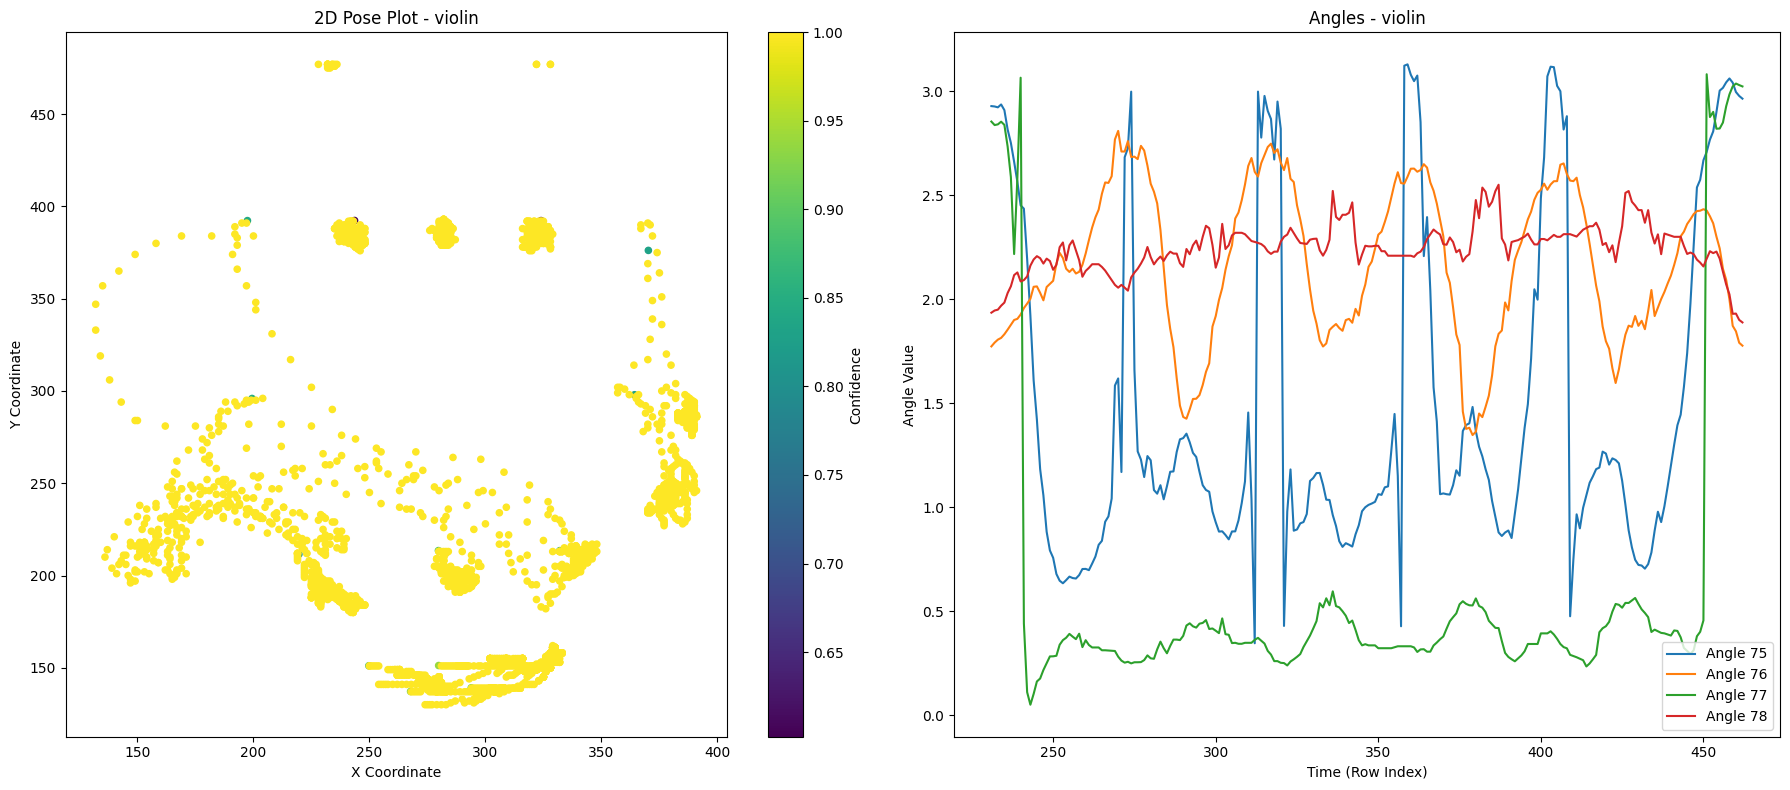

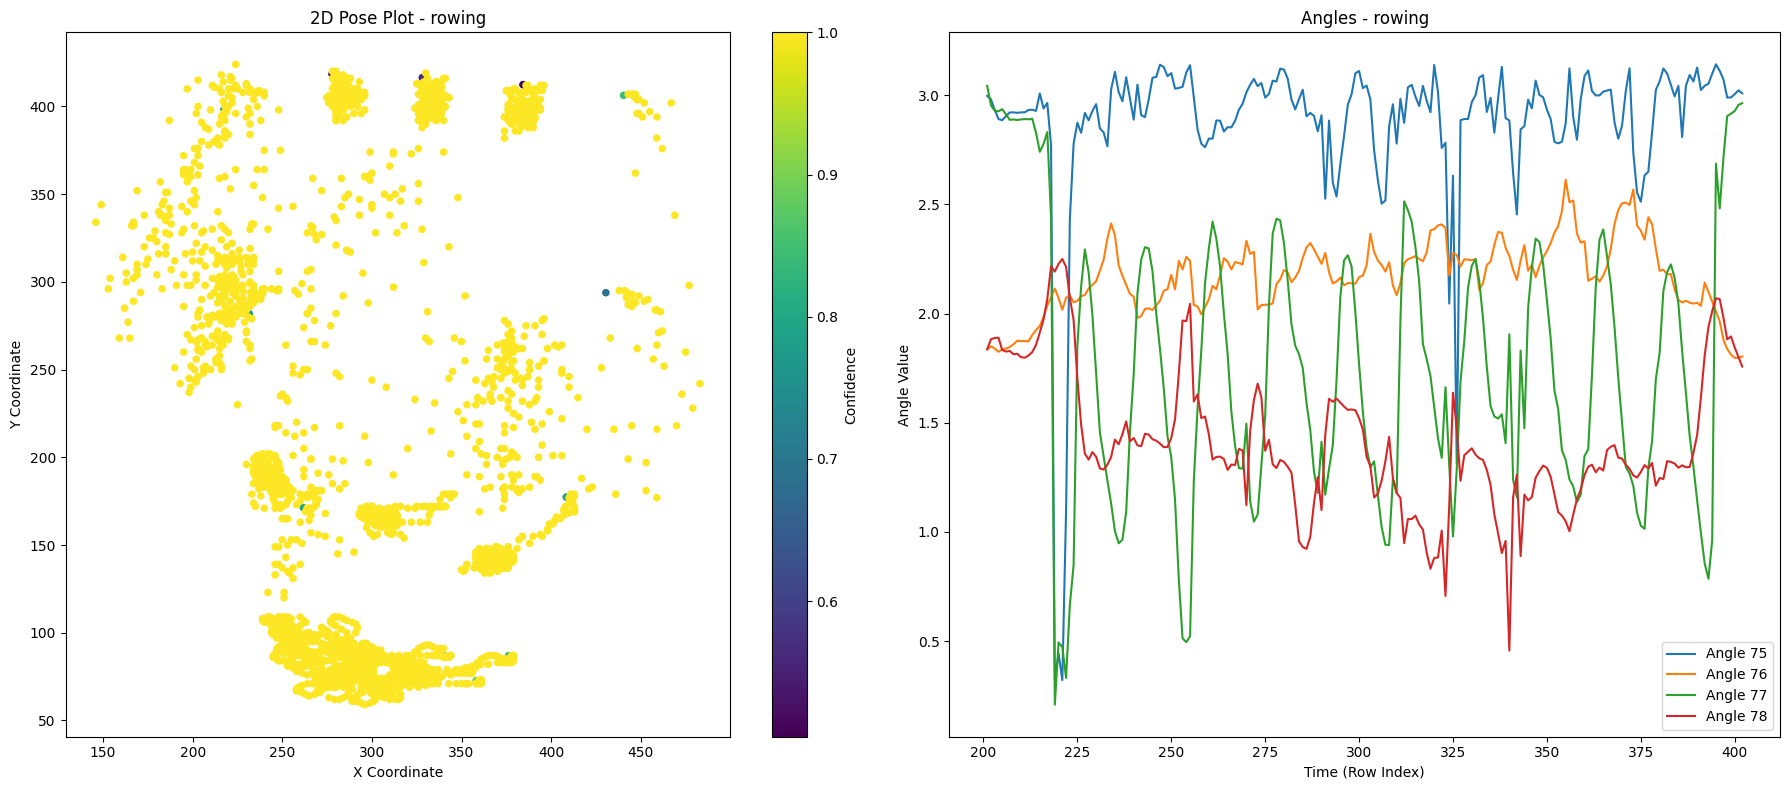

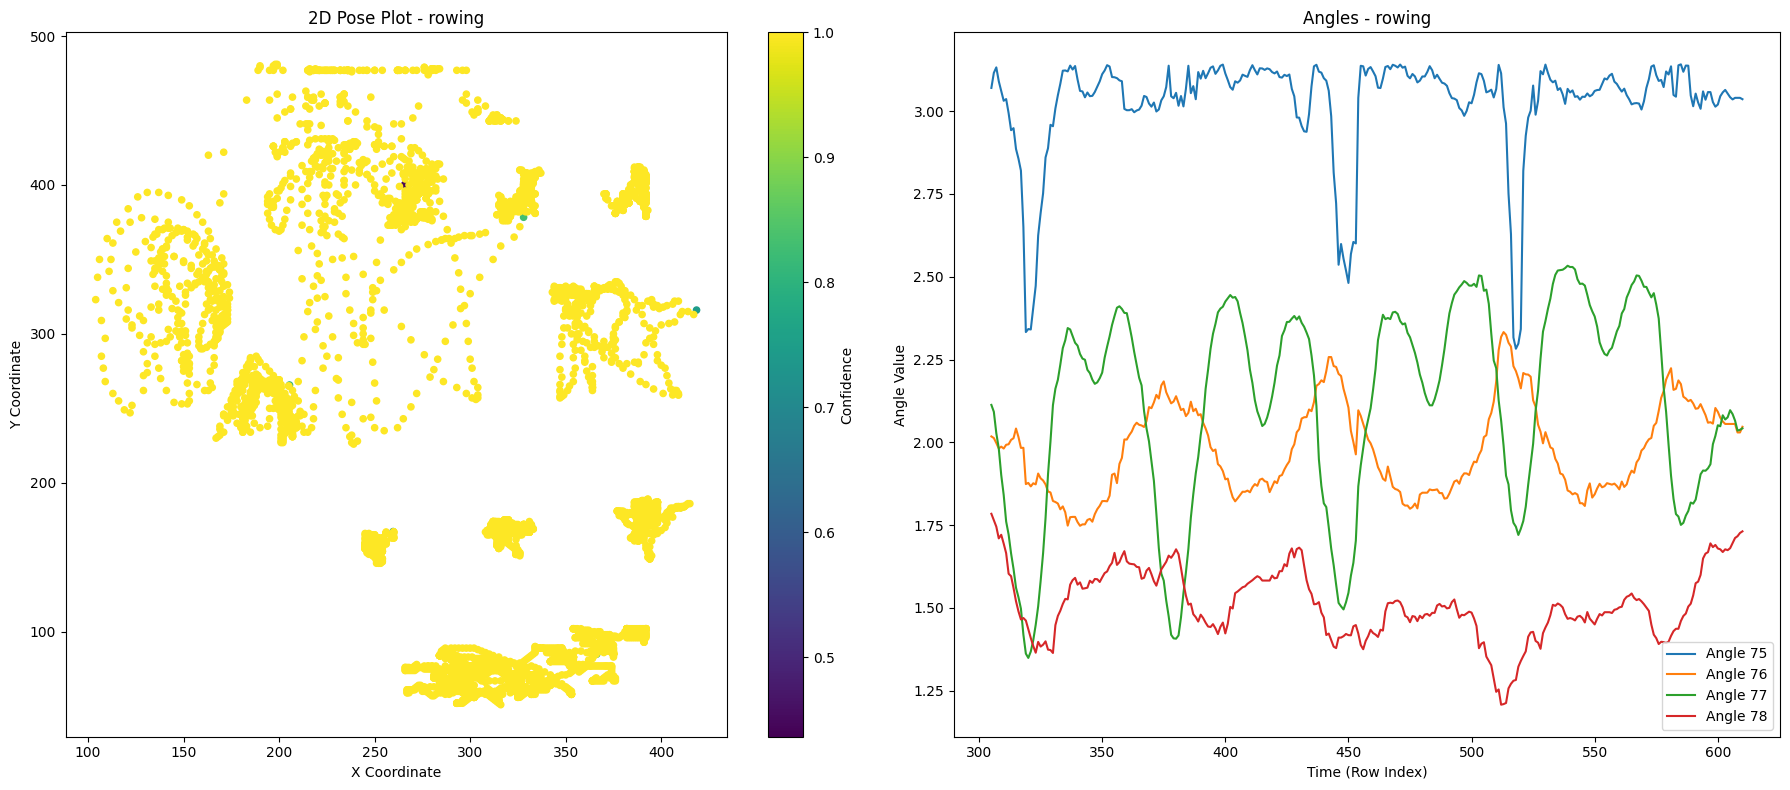

In [ ]:
# Defining keypoint and angle indices
np.random.seed(42)
keypoint_indices = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72]
angle_indices = [75, 76, 77, 78]
for i in np.random.choice(range(1167), 3):
    visualize_poses_and_angles(filtered_dataframes[i], keypoint_indices, angle_indices, label_name=movement_labels[i], num_rows=None)


In [ ]:
# Keeping the first 75 columns and the first half of the rows in each dataframe
final_dataframes = [df.iloc[:, :75] for df in filtered_dataframes]

# Displaying the shape of the first few trimmed dataframes
for i, df in enumerate(final_dataframes[:5]):
    print(f"DataFrame {i+1} shape: {df.shape}")


DataFrame 1 shape: (165, 75)
DataFrame 2 shape: (349, 75)
DataFrame 3 shape: (307, 75)
DataFrame 4 shape: (245, 75)
DataFrame 5 shape: (163, 75)


In [ ]:
for df in final_dataframes:
    columns_to_drop = [i for i in range(2, 75, 3)]
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
final_dataframes[0]

,0,1,3,4,6,7,9,10,12,13,...,60,61,63,64,66,67,69,70,72,73
164,316.017761,109.033302,313.902222,203.429169,245.591904,201.521133,219.604935,311.996185,215.443985,424.441772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,215.000000,425.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,214.000000,426.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,213.000000,427.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,211.000000,426.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,328.000000,111.000000,319.000000,202.000000,250.000000,201.000000,230.000000,307.000000,213.000000,414.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,327.000000,111.000000,319.000000,202.000000,249.000000,201.000000,230.000000,307.000000,211.000000,414.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326,326.000000,111.000000,317.000000,202.000000,249.000000,201.000000,230.000000,310.000000,209.000000,414.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,325.000000,111.000000,317.000000,202.000000,249.000000,201.000000,230.000000,310.000000,207.000000,414.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Find the lengths of all dataframes
lengths = [len(df) for df in final_dataframes]

# Find the minimum and maximum lengths
min_length = min(lengths)
max_length = max(lengths)

print(f"Minimum length: {min_length}")
print(f"Maximum length: {max_length}")

Minimum length: 103
Maximum length: 945


In [ ]:
def cut_data(data_frame_list, max_rows=103):
    cut_data_frame_list = []
    for df in data_frame_list:
        if len(df) > max_rows:
            cut_df = df.iloc[:max_rows].copy()  # 创建一个副本
        else:
            cut_df = df.reindex(range(max_rows)).fillna(0).copy()  # 重建索引，填充0，然后创建副本
        cut_data_frame_list.append(cut_df)
    return cut_data_frame_list

train_cut_data = cut_data(final_dataframes)

In [ ]:
train_cut_data[0]

,0,1,3,4,6,7,9,10,12,13,...,60,61,63,64,66,67,69,70,72,73
164,316.017761,109.033302,313.902222,203.429169,245.591904,201.521133,219.604935,311.996185,215.443985,424.441772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,215.000000,425.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,214.000000,426.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,213.000000,427.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,316.000000,109.000000,314.000000,203.000000,246.000000,202.000000,219.000000,313.000000,211.000000,426.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,356.000000,119.000000,338.000000,199.000000,273.000000,186.000000,249.000000,261.000000,348.000000,264.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,354.000000,119.000000,337.000000,199.000000,271.000000,186.000000,250.000000,260.000000,354.000000,248.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,352.000000,119.000000,337.000000,199.000000,271.000000,186.000000,262.000000,262.000000,364.000000,238.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,351.000000,119.000000,335.000000,198.000000,270.000000,185.000000,263.000000,261.000000,376.000000,230.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Initialize lists to store means and standard deviations
means = []
stds = []

# Calculate mean and standard deviation for each column across all dataframes
for i in range(train_cut_data[0].shape[1]):
    column_values = pd.concat([df.iloc[:, i] for df in train_cut_data])
    means.append(column_values.mean())
    stds.append(column_values.std())


In [ ]:
# List for storing normalized dataframes
normalized_dataframes = []

# Normalizing each dataframe
for df in train_cut_data:
    normalized_df = df.copy()
    for i in range(normalized_df.shape[1]):
        normalized_df.iloc[:, i] = (normalized_df.iloc[:, i] - means[i]) / stds[i]
    normalized_dataframes.append(normalized_df.fillna(0))


In [ ]:
normalized_dataframes[0]

,0,1,3,4,6,7,9,10,12,13,...,60,61,63,64,66,67,69,70,72,73
164,0.111626,0.399049,-0.014700,1.459614,-0.177280,1.305847,0.144395,1.380299,-0.567599,2.006483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,0.111026,0.397538,-0.010846,1.437311,-0.160888,1.330194,0.127302,1.408783,-0.575098,2.014008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,0.111026,0.397538,-0.010846,1.437311,-0.160888,1.330194,0.127302,1.408783,-0.591988,2.027487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,0.111026,0.397538,-0.010846,1.437311,-0.160888,1.330194,0.127302,1.408783,-0.608877,2.040967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.111026,0.397538,-0.010846,1.437311,-0.160888,1.330194,0.127302,1.408783,-0.642657,2.027487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,1.462180,0.851315,0.935008,1.229442,0.923644,0.516684,0.974960,-0.066735,1.671230,-0.156185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,1.394623,0.851315,0.895598,1.229442,0.843308,0.516684,1.003215,-0.095111,1.772568,-0.371857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,1.327065,0.851315,0.895598,1.229442,0.843308,0.516684,1.342279,-0.038360,1.941465,-0.506651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,1.293286,0.851315,0.816777,1.177475,0.803140,0.465839,1.370534,-0.066735,2.144141,-0.614487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# def normalize_train(df):
#     normalization_params = {}
#     df_normalized = df.copy()
#     for column in df.columns:
#         if df_normalized[column].dtype in ['int64', 'float64']:
#             min_value = df_normalized[column].min()
#             max_value = df_normalized[column].max()
#             # Use .loc to ensure you're modifying the DataFrame
#             df_normalized.loc[:, column] = (df_normalized[column] - min_value) / (max_value - min_value)
#             normalization_params[column] = (min_value, max_value)
#     return df_normalized, normalization_params


In [ ]:
# # Normalizing the training dataframes
# normalized_train_dataframes = []
# train_normalization_params = []
# for df in train_cut_data:
#     normalized_df, params = normalize_train(df)
#     normalized_train_dataframes.append(normalized_df.fillna(0))
#     train_normalization_params.append(params)

In [ ]:
# normalized_train_dataframes[0]

In [ ]:
# Your label mapping
label_mapping = {
    "boxing": 0,
    "drums": 1,
    "guitar": 2,
    "rowing": 3,
    "violin": 4
}

# Assuming 'labels' is your list of original labels
original_labels = ["boxing", "drums", "guitar", "rowing", "violin"]

# Map the original labels to their corresponding numbers
train_labels_df = [label_mapping[label] for label in movement_labels]

# Display the mapped labels
print(train_labels_df)


[4, 3, 3, 2, 2, 3, 2, 4, 3, 4, 2, 2, 4, 3, 3, 1, 2, 2, 1, 1, 4, 3, 1, 4, 0, 4, 4, 4, 1, 4, 4, 2, 1, 0, 2, 4, 0, 1, 3, 2, 3, 4, 2, 0, 4, 3, 4, 2, 4, 1, 0, 2, 4, 4, 3, 1, 0, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 4, 0, 2, 3, 4, 1, 3, 3, 0, 4, 0, 1, 2, 4, 2, 4, 3, 3, 4, 3, 0, 4, 1, 1, 1, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 1, 2, 1, 1, 3, 4, 1, 2, 2, 1, 3, 3, 1, 2, 0, 0, 4, 1, 1, 0, 0, 3, 0, 2, 1, 0, 4, 1, 3, 0, 4, 0, 0, 3, 1, 1, 4, 4, 1, 2, 1, 2, 2, 3, 0, 1, 3, 3, 4, 0, 3, 2, 3, 3, 4, 3, 4, 4, 1, 2, 2, 4, 3, 0, 3, 1, 3, 0, 0, 0, 3, 2, 3, 2, 0, 2, 2, 3, 4, 3, 1, 3, 1, 4, 2, 4, 4, 1, 0, 1, 0, 0, 1, 0, 4, 0, 1, 1, 2, 3, 4, 1, 2, 3, 1, 3, 0, 3, 1, 3, 0, 3, 4, 3, 0, 4, 4, 0, 0, 4, 0, 0, 0, 3, 1, 0, 1, 3, 4, 4, 1, 4, 2, 1, 2, 0, 0, 4, 1, 4, 0, 2, 2, 3, 1, 2, 0, 2, 0, 1, 0, 3, 0, 3, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 3, 1, 2, 2, 3, 0, 0, 4, 3, 4, 1, 0, 4, 0, 4, 4, 0, 0, 1, 2, 3, 0, 2, 4, 3, 0, 2, 3, 2, 4, 1, 3, 0, 0, 1, 4, 3, 4, 2, 4, 0, 4, 4, 1, 2, 4, 1, 0, 0, 2, 2, 1, 1, 4, 1, 1, 2, 1, 0, 0, 1, 1, 4, 0, 1, 4, 3, 

In [ ]:
# Converting to tensors
X_tensor = torch.tensor([df.values for df in normalized_dataframes], dtype=torch.float32)
# y_tensor = torch.tensor(train_labels_df['label'].values, dtype=torch.long).squeeze()
y_tensor = torch.tensor(train_labels_df, dtype=torch.long)

# train_test-split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)




<ipython-input-27-0ca9f6a83031>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_tensor = torch.tensor([df.values for df in normalized_dataframes], dtype=torch.float32)


In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([933, 103, 50]),
 torch.Size([234, 103, 50]),
 torch.Size([933]),
 torch.Size([234]))

### Modeling

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import resample
import torch.nn.functional as F

In [ ]:
def cnn_train(train_data, train_label, test_data, test_label, out_channels, epochs=10, batch_size=32, learning_rate=0.001, cuda=True, plots=True):
    # Convert train and test data and labels to tensors, and adjust the shape
    X_train_tensor = torch.Tensor(train_data).transpose(1, 2)  # Transpose to get [batch, channels, length]
    y_train_tensor = torch.LongTensor(train_label)
    X_test_tensor = torch.Tensor(test_data).transpose(1, 2)  # Transpose to get [batch, channels, length]
    y_test_tensor = torch.LongTensor(test_label)

    # Create TensorDatasets for train and test datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders for train and test datasets
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize input and class dimensions
    in_channels = train_data.shape[2]  # 50
    class_dim = 5  # Number of classes
    current_size = train_data.shape[1]  # 150

    # Check if CUDA is available and set device accordingly
    device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")

    # Initialize the CNN model
    cnn_model = nn.Sequential()
    for i, channels in enumerate(out_channels):
        cnn_model.add_module(f'conv_block{i}', nn.Sequential(
            nn.Conv1d(in_channels, channels, kernel_size=5, padding=1),
            nn.ReLU()
        ))
        in_channels = channels
        # kernel_size=5, padding=1, stride=1
        current_size = (current_size - 5 + 2 * 1) // 1 + 1
    cnn_model.add_module('flatten', nn.Flatten())
    fc_input_size = in_channels * current_size  # Size after flattening

    cnn_model.add_module('output_layer', nn.Linear(fc_input_size, class_dim))
    cnn_model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(epochs):
        cnn_model.train()
        correct_train = 0
        total_train = 0
        for x_batch, y_batch in train_data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            train_preds = cnn_model(x_batch)
            train_loss = loss_func(train_preds, y_batch)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            train_losses.append(train_loss.item())

            _, predicted_train = torch.max(train_preds.data, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted_train == y_batch).sum().item()

        train_acc = 100 * correct_train / total_train
        train_accuracy.append(train_acc)

        cnn_model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for x_batch, y_batch in test_data_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                test_preds = cnn_model(x_batch)
                test_loss = loss_func(test_preds, y_batch)
                test_losses.append(test_loss.item())

                _, predicted_test = torch.max(test_preds.data, 1)
                total_test += y_batch.size(0)
                correct_test += (predicted_test == y_batch).sum().item()

            test_acc = 100 * correct_test / total_test
            test_accuracy.append(test_acc)

        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    if plots:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Testing Loss')
        plt.title('Loss over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy, label='Training Accuracy')
        plt.plot(test_accuracy, label='Testing Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    return cnn_model



Epoch: 1/10, Train Loss: 1.4811, Train Acc: 35.48%, Test Loss: 1.5493, Test Acc: 53.42%
Epoch: 2/10, Train Loss: 0.9765, Train Acc: 57.02%, Test Loss: 1.4507, Test Acc: 64.10%
Epoch: 3/10, Train Loss: 0.5733, Train Acc: 71.81%, Test Loss: 1.0109, Test Acc: 81.20%
Epoch: 4/10, Train Loss: 0.6369, Train Acc: 86.07%, Test Loss: 0.7101, Test Acc: 86.75%
Epoch: 5/10, Train Loss: 0.1591, Train Acc: 91.75%, Test Loss: 0.7624, Test Acc: 94.02%
Epoch: 6/10, Train Loss: 0.3575, Train Acc: 95.39%, Test Loss: 0.7540, Test Acc: 92.74%
Epoch: 7/10, Train Loss: 0.1309, Train Acc: 95.71%, Test Loss: 0.5018, Test Acc: 94.44%
Epoch: 8/10, Train Loss: 0.0930, Train Acc: 96.78%, Test Loss: 0.7596, Test Acc: 94.87%
Epoch: 9/10, Train Loss: 0.0863, Train Acc: 97.96%, Test Loss: 0.6379, Test Acc: 96.15%
Epoch: 10/10, Train Loss: 0.1259, Train Acc: 97.96%, Test Loss: 0.9771, Test Acc: 95.30%


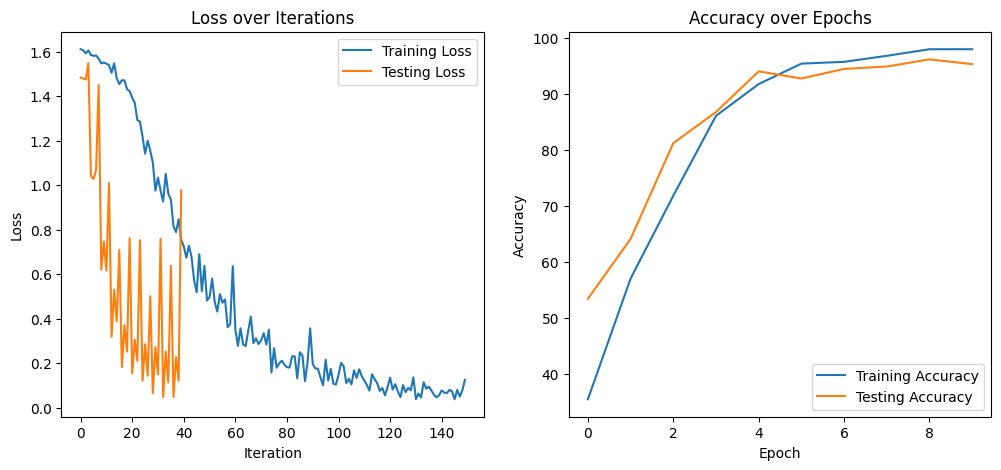

In [ ]:
# user paramters
out_channels = [256, 128, 64]  # list of hidden layer dimensions
epochs = 10 # number of epochs
batch_size = 64  # training batch size
learning_rate = 0.0001  # learning rate
cuda = True  # true or false to train the model on cuda or not
plots = True
model_3 = cnn_train(train_data = X_train, train_label = y_train ,test_data = X_val, test_label = y_val, out_channels = out_channels, epochs = epochs,  batch_size = batch_size, learning_rate = learning_rate,cuda = cuda, plots = plots)


In [ ]:
def get_prediction(model, data, use_cuda=True):
    # Check if CUDA is available and set device accordingly
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    # Ensure the model is in evaluation mode
    model.eval()

    # Adjust the data format to match the model input
    # The model expects data in the shape [batch, channels, length]
    data = data.transpose(1, 2)  # Swap the second and third dimension

    # Move the data to the correct device
    data = data.to(device)

    with torch.inference_mode():
        # Get model predictions
        y_logits = model(data)

        # Convert logits to probabilities
        y_pred_probs = torch.softmax(y_logits, dim=1)

        # Get the predicted labels
        y_preds = y_pred_probs.argmax(dim=1)

        # Display the first 10 predictions
        print(f"Predictions: {y_preds[:10]}")

    return y_preds


In [ ]:
y_pred = get_prediction(model_3,  X_val)

Predictions: tensor([1, 0, 3, 3, 2, 0, 3, 2, 0, 4], device='cuda:0')


In [ ]:
y_pred = y_pred.to("cpu")

In [ ]:
y_val

tensor([1, 0, 3, 3, 2, 0, 3, 2, 0, 4, 4, 1, 2, 4, 2, 4, 1, 1, 4, 4, 2, 1, 4, 4,
        1, 0, 1, 0, 3, 0, 0, 2, 4, 3, 3, 3, 4, 2, 2, 0, 0, 1, 1, 4, 4, 0, 1, 0,
        4, 1, 4, 2, 3, 2, 0, 1, 2, 1, 3, 1, 4, 4, 4, 3, 0, 1, 4, 0, 4, 2, 4, 3,
        3, 4, 1, 1, 2, 3, 4, 1, 4, 2, 4, 4, 2, 3, 4, 3, 1, 4, 1, 4, 2, 0, 3, 1,
        3, 2, 4, 2, 4, 4, 0, 2, 1, 3, 0, 4, 3, 3, 1, 3, 2, 4, 3, 4, 0, 0, 0, 0,
        4, 1, 4, 2, 1, 1, 0, 4, 4, 0, 0, 1, 1, 0, 4, 4, 3, 1, 0, 0, 2, 3, 3, 2,
        0, 3, 4, 4, 0, 4, 4, 4, 2, 0, 3, 0, 0, 0, 1, 1, 4, 2, 1, 1, 0, 3, 2, 2,
        1, 2, 2, 2, 3, 3, 0, 1, 1, 1, 3, 4, 0, 2, 0, 0, 0, 1, 2, 0, 2, 3, 4, 3,
        3, 2, 2, 0, 0, 1, 4, 3, 2, 1, 1, 3, 0, 0, 4, 1, 4, 3, 2, 2, 1, 2, 4, 0,
        2, 4, 1, 3, 2, 4, 2, 2, 2, 3, 4, 0, 4, 1, 2, 3, 1, 2])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and print confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9529914529914529
Precision: 0.953639341031721
Recall: 0.9552795031055901
F1 Score: 0.954069082475451
Confusion Matrix:
[[44  1  0  0  1]
 [ 2 42  0  1  1]
 [ 0  0 45  0  1]
 [ 0  0  0 40  0]
 [ 1  0  2  1 52]]


1. Estimating Memory and Runtime Complexity
Theoretical Complexity:

Memory Complexity:

Training: Memory usage during training depends on the size of the model (number of parameters), the size of the training data, and batch size. In a neural network, memory is required for weights, biases, activations at each layer, and gradients during backpropagation.

Testing: Memory usage during testing is generally lower, as it only requires memory for the model parameters and a single instance or a batch of test data. There's no need to store gradients or activations from multiple layers.

Runtime Complexity:

Training: The runtime complexity depends on the number of epochs, number of layers in the model, and the complexity of each layer (for a dense layer, it is often proportional to the product of input and output sizes). The training time also includes forward and backward passes.
Testing: Runtime complexity during testing is typically lower. It involves a single forward pass through the network for each instance or batch of data.

Practical Complexity:

The practical complexity might differ based on the hardware used (CPU vs. GPU), optimization in code, and data loading mechanisms.

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [ ]:
!jupyter nbconvert --to pdf /content/Final_notebook_portfolio_3.ipynb

[NbConvertApp] Converting notebook /content/Final_notebook_portfolio_3.ipynb to pdf
[NbConvertApp] Support files will be in Final_notebook_portfolio_3_files/
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Making directory ./Final_notebook_portfolio_3_files
[NbConvertApp] Writing 258048 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp]